In [1]:
import datetime
import smtplib
from email.mime.text import MIMEText
import QUANTAXIS as QA
try:
    assert QA.__version__>='1.1.0'
except AssertionError:
    print('pip install QUANTAXIS >= 1.1.0 请升级QUANTAXIS后再运行此示例')
    import QUANTAXIS as QA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import abupy
from abupy import ABuRegUtil
from concurrent.futures import ThreadPoolExecutor
from functools import reduce
import warnings
read_dictionary = np.load('/home/mildone/Project/quanaly/liutong.npy',allow_pickle=True).item()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtk
import mpl_finance as mpf

def MACACalculate(sample):
    rate=0.015
    sample['EMA12']=QA.EMA(sample.close,12)
    sample['EMA13']=QA.EMA(sample.close,13)
    sample['optimism']=sample.high-sample.EMA13
    sample['pessmist']=sample.low-sample.EMA13
    sample['up']=sample.EMA13*(1+rate)
    sample['down']=sample.EMA13*(1-rate)
    sample['EMA26']=QA.EMA(sample.close,26)
    sample['MACDQ']=sample['EMA12']-sample['EMA26']
    sample['MACDSIG']=QA.EMA(sample['MACDQ'],9)
    sample['MACDBlock']=sample['MACDQ']-sample['MACDSIG']
    sroc=[]
    for i in range(sample.shape[0]):
        if(i-21>0 and sample.iloc[i].EMA13 != None and sample.iloc[i-21].EMA13!=None):
            #print(sample.iloc[i].EMA13/sample.iloc[i-21].EMA13)
            sroc.append((sample.iloc[i].EMA13/sample.iloc[i-21].EMA13)*100)
        else:
            sroc.append(100)
    sample['SROC']=sroc
    size = sample.shape[0]
    single =[0]
    for i in range(sample.shape[0]):    
        if(sample.MACDBlock[i-1]<0 and sample.MACDBlock[i]>=0 and i-1>=0):
            print(sample.index.get_level_values('date')[i])
            single.append(1)
        elif(sample.MACDBlock[i-1]>=0 and sample.MACDBlock[i]<0 and i):
            single.append(3)
        else:
            single.append(0)
    for i in range(sample.shape[0]):
        if(single[i]==1 and i+3<size):
            single[i+3]=3
    single.pop()
    sample['single']=single      
    
    return sample
    
def candlestruct(sample):
    import matplotlib.dates as mpd
    quotes=[]
    pydate_array = sample.index.get_level_values('date').to_pydatetime()
    date_only_array = np.vectorize(lambda s: s.strftime('%Y-%m-%d'))(pydate_array )
#date_only_series = pd.Series(date_only_array)
    N=sample.index.get_level_values('date').shape[0]
    ind = np.arange(N)
    for i in range(len(sample)):
        li=[]
    #datet=datetime.datetime.strptime(sample.index.get_level_values('date'),'%Y%m%d')   #字符串日期转换成日期格式
        #datef=mpd.date2num(datetime.datetime.strptime(date_only_array[i],'%Y-%m-%d')) 
        datef=ind[i]#日期转换成float days
        open_p=sample.open[i]
        close_p=sample.close[i]
        high_p=sample.high[i]
        low_p=sample.low[i]
        li=[datef,open_p,close_p,high_p,low_p]
        t=tuple(li)
        quotes.append(t)
    return quotes

def MACDPLOT(sample):
    quotes = candlestruct(sample)
    N=sample.index.get_level_values('date').shape[0]
    ind = np.arange(N)
    def format_date(x, pos=None):
        thisind = np.clip(int(x+0.5), 0, N-1)
        return sample.index.get_level_values('date')[thisind].strftime('%Y-%m-%d')
    fig = plt.figure()
    fig.set_size_inches(20.5,12.5)
    #plt.xlabel('Trading Day')
    #plt.ylabel('MACD EMA')
    ax2 = fig.add_subplot(4,1,1)
    ax2.set_title("candlestick")
  
    
    #fig,ax=plt.subplots()
    #mpf.candlestick_ochl(ax2,quotes,width=0.2,colorup='r',colordown='g',alpha=1.0)
    #ax2.xaxis_date()
    #plt.setp(plt.gca().get_xticklabels(),rotation=30)
    #ax2.plot(ind,sample.close,'b-',marker='*')
    mpf.candlestick_ochl(ax2,quotes,width=0.6,colorup='r',colordown='g',alpha=1.0)
    ax2.xaxis.set_major_formatter(mtk.FuncFormatter(format_date))
    ax2.plot(ind,sample.up,'r-')
    ax2.plot(ind,sample.down,'b-')
    ax2.grid(True)
    #t.legend()
    fig.autofmt_xdate()
    
    ax4 = fig.add_subplot(4,1,2,sharex=ax2)
    ax4.set_title("EMA13/SROC21")
    #ax1 = ax2.twinx()   #not working like it's 
    ax4.plot(ind,sample.SROC,'r-')
    ax4.grid(True)
    ax4.xaxis.set_major_formatter(mtk.FuncFormatter(format_date))
    fig.autofmt_xdate()
    
    
    
    ax3 = fig.add_subplot(4,1,4,sharex=ax2)
    ax3.set_title("volume")
    #ax1 = ax2.twinx()   #not working like it's 
    ax3.bar(ind,sample.volume)
    ax3.grid(True)
    ax3.xaxis.set_major_formatter(mtk.FuncFormatter(format_date))
    fig.autofmt_xdate()
    
    ax1 = fig.add_subplot(4,1,3,sharex=ax2)
    ax1.set_title('macd')
    ax1.grid(True)
    ax1.plot(ind,sample.MACDQ,'r-',marker='*')
    ax1.plot(ind,sample.MACDSIG,'o-')
    ax1.bar(ind,sample.MACDBlock)
    ax1.xaxis.set_major_formatter(mtk.FuncFormatter(format_date))
    #ax2.set_yticks(np.linspace(ax2.get_yticks()[0], ax2.get_yticks()[-1], len(ax1.get_yticks())))
    fig.autofmt_xdate()
    plt.legend()
    
    
    code = sample.index.get_level_values('code')[0]
    
    plt.savefig('/home/mildone/monitor/'+'Trend'+code+'.png')
    plt.show()
    plt.close()

def amountAnalyse(buydata):
    """
    @buydata as pdDataFrame
    e.g. buydata = QA.QA_fetch_get_stock_transaction_realtime('pytdx','600797') get current day's transaction
    e.g. data1=QA.QAFetch.QATdx.QA_fetch_get_stock_transaction('600797','2019-01-01','2019-04-11') get transaction among period of time
    
    """
    sellone = buydata[buydata['buyorsell']==1]
    sellone['amount'] = sellone['price']*sellone['vol']
    sellone.sort_values("vol",inplace=True,ascending=False)

    buyone = buydata[buydata['buyorsell']==0]
    buyone['amount'] = buyone['price']*buyone['vol']
    buyone.sort_values("vol",inplace=True,ascending=False)
    #print("Top buyer vol")
    #buyone[buyone['vol']>10]
    print("Top Seller vol")
    sellone.head(100)
def getStocklist():
    """
    get all stock as list 
    usage as: 
    QA.QA_util_log_info('GET STOCK LIST')
    stocks=getStocklist()
    """
    data=QA.QAFetch.QATdx.QA_fetch_get_stock_list('stock')
    stock = data['code'].index
    stocklist = []
    for code in stock:
        stocklist.append(code[0])
    return stocklist
def loadLocalData(stocks,start_date ='2018-03-15',end_date = '2019-09-07'):
    """
    data() as pdDataFrame
    stocks could be list of all the stock or some. if you pass single one e.g. 000001 it will get one only
    to get dedicated stock, using below method, and notice stockp() will be dataFrame
    stockp = data.select_code(stock)
    
    
    """
    QA.QA_util_log_info('load data from local DB')
    data=QA.QA_fetch_stock_day_adv(stocks,start_date,end_date)
    return data
def loadFromCopy(file):
    """
    loaddata from file copy
    """
    return pd.DataFrame(pd.read_csv(file))

def calAngle(df):
    """
    trend angle based on provided dataframe 
    """
    return ABuRegUtil.calc_regress_deg(df.close.values,show=False)

def getData(df, code):
    """
    split data per code from all market data 
    """
    return df[df.code==code].reset_index(drop=True)

def trendBreak(pdDataFrame):
    """
    trendBreak based on provdied market data 
    """
   
    from abupy import pd_rolling_max
    from abupy import pd_expanding_max
    # 当天收盘价格超过N1天内最高价格作为买入信号
    N1 = 20
    # 当天收盘价格超过N2天内最低价格作为卖出信号
    N2 = 15
    kl_pd = pdDataFrame
    # 通过rolling_max方法计算最近N1个交易日的最高价
    # kl_pd['n1_high'] = pd.rolling_max(kl_pd['high'], window=N1)
    kl_pd['n1_high'] = pd_rolling_max(kl_pd['high'], window=N1)
    # 表7-4所示

    # expanding_max
    # expan_max = pd.expanding_max(kl_pd['close'])
    expan_max = pd_expanding_max(kl_pd['close'])
    # fillna使用序列对应的expan_max
    kl_pd['n1_high'].fillna(value=expan_max, inplace=True)
    # 表7-5所示
    #print('kl_pd[0:5]:\n', kl_pd[0:5])

    from abupy import pd_rolling_min, pd_expanding_min
    # 通过rolling_min方法计算最近N2个交易日的最低价格
    # rolling_min与rolling_max类似
    # kl_pd['n2_low'] = pd.rolling_min(kl_pd['low'], window=N2)
    kl_pd['n2_low'] = pd_rolling_min(kl_pd['low'], window=N2)
    # expanding_min与expanding_max类似
    # expan_min = pd.expanding_min(kl_pd['close'])
    expan_min = pd_expanding_min(kl_pd['close'])
    # fillna使用序列对应的eexpan_min
    kl_pd['n2_low'].fillna(value=expan_min, inplace=True)

    # 当天收盘价格超过N天内的最高价或最低价, 超过最高价格作为买入信号买入股票持有
    buy_index = kl_pd[kl_pd['close'] > kl_pd['n1_high'].shift(1)].index
    kl_pd.loc[buy_index, 'signal'] = 1

    # 当天收盘价格超过N天内的最高价或最低价, 超过最低价格作为卖出信号
    sell_index = kl_pd[kl_pd['close'] < kl_pd['n2_low'].shift(1)].index
    kl_pd.loc[sell_index, 'signal'] = 0

    #kl_pd.signal.value_counts().plot(kind='pie', figsize=(5, 5))
    #plt.show()

    """
        将信号操作序列移动一个单位，代表第二天再将操作信号执行，转换得到持股状态
        这里不shift(1)也可以，代表信号产生当天执行，但是由于收盘价格是在收盘后
        才确定的，计算突破使用了收盘价格，所以使用shift(1)更接近真实情况
    """
    kl_pd['keep'] = kl_pd['signal'].shift(1)
    kl_pd['keep'].fillna(method='ffill', inplace=True)
    return kl_pd

    # 计算基准收益
    #kl_pd['benchmark_profit'] = np.log(
        #kl_pd['close'] / kl_pd['close'].shift(1))

    # 计算使用趋势突破策略的收益
    #kl_pd['trend_profit'] = kl_pd['keep'] * kl_pd['benchmark_profit']

    # 可视化收益的情况对比
    #kl_pd[['benchmark_profit', 'trend_profit']].cumsum().plot(grid=True,
        #                                                      figsize=(
        #                                                          14, 7))
    #plt.show()
    #kl_pd[['n2_low','n1_high','close']].plot(grid=True,figsize=(14,7))
    #kl_pd.close.plot(grid=True,figsize=(14.7))
    #plt.show()

def execute(stocks,data): 
    select=[]
    for stock in stocks: 
        try:
            QA.QA_util_log_info('dealting with {}'.format(stock))
            stockp = data.select_code(stock)
            if (trend(stockp[-10:])>0 and trend(stockp[-10:])<10):
                select.append(stock)
        except:
            print('wrong with {}'.format(stock))

    return sorted(select)[-2:]


def executeParallel(stocks,data): 
    """
    scan all data and filter out ones doing trendbreak
    """
    alldep=[]
    with ThreadPoolExecutor(5) as executor:
        for stock , dep in zip(stocks,executor.map(trendSingle,alldata)):
            alldep.append((stock,dep))
    print('all done')          
    return alldep

def init_change(df):
    #change first (d[i].close-d[i-1].close)/d[i-1].close
    pp_array = [float(close) for close in df.close]
    temp_array = [(price1, price2) for price1,price2 in zip(pp_array[:-1],pp_array[1:])]
    change = list(map(lambda pp: reduce(lambda a, b: round((b - a) / a, 3), pp), temp_array))
    change.insert(0,0)
    df['change'] = change
    #amplitude (d[i].high-d[i].low)/d[i-1].close) 
    amp_arry=[float(amp) for amp in (df.high-df.low)]
    amp_temp =  [(price1, price2) for price1,price2 in zip(amp_arry[:-1],pp_array[1:])]
    amplitude = list(map(lambda pp: reduce(lambda a, b: round(a/b, 3), pp), amp_temp))
    amplitude.insert(0,0)
    df['amplitude'] = amplitude
    #sratio = QA.QA_fetch_get_stock_info(df.index.get_level_values('code')[0]).liutongguben[0]
    sratio = read_dictionary[df.index.get_level_values('code')[0]]
    df['SR']=df['volume']/sratio*100
    
    
def init_trend(df,period=7):
    """
    period can be set based on situation. 
    detect the angle change form negative to positive 
    """
    trend=[]
    ratio = []
    for i in range(0,df.shape[0]):
        #print(i)
        if(i<period):
            trend.append(calAngle(df.iloc[:period]))
            ratio.append(df.iloc[i].amount*period/sum(df.iloc[0:period].amount))
        else:
            trend.append(calAngle(df.iloc[i-period+1:i+1]))
            ratio.append(df.iloc[i].amount*5/sum(df.iloc[i-5:i].amount))
    df['trend']=trend
    df['amountRatio'] = ratio
"""

def trendSingle(df):
   
    buydate=[]
    for i in range(0,df.shape[0]):
        if(df.iloc[i].amountRatio>1 and df.iloc[i].trend>1 and df.iloc[i].amplitude<0.07 and df.iloc[i].change<0.03 
          and df.iloc[i].change>0.01):
            buydate.append((i,df.iloc[i].date))
    return buydate
"""

def trendSingle(df,period=7):
    """
    @paramater dataframe 
    return True or False
    Justification:
    1. latest 20 days angle >0
    2. change (0.1~0.3)
    3. 
    
    """
    #df['trend']=0
    #df['amountRatio']=0
    #trend=0
    #amountRatio=0
    keep = 5
    init_change(df)
    init_trend(df)
    single=[0,0]
    #temp =[]
    for i in range(1,df.shape[0]):
        """
        if(i<period):
            #trend.append(calAngle(df.iloc[:period]))
            trend=calAngle(df.iloc[:period])
            #print(trend)
            #ratio.append(df.iloc[i].amount*period/sum(df.iloc[0:period].amount))
            amountRatio=df.iloc[i].amount*period/sum(df.iloc[0:period].amount)
        else:
            #trend.append(calAngle(df.iloc[i-period+1:i+1]))
            trend=calAngle(df.iloc[i-period+1:i+1])
            #print(trend)
            #print(calAngle(df.iloc[i-period+1:i+1]))
            #ratio.append(df.iloc[i].amount*5/sum(df.iloc[i-5:i].amount))
            #print(df.iloc[i].amount*5/sum(df.iloc[i-5:i].amount))
            amountRatio=df.iloc[i].amount*5/sum(df.iloc[i-5:i].amount)
        """
        if(1.5>df.iloc[i].amountRatio>1 and df.iloc[i].trend>1 and df.iloc[i].amplitude>0.05
           and 0.01<df.iloc[i].change<0.03 and df.iloc[i].SR <0.05 ):
            single.append(1)
        else:
            single.append(0)
    #single.append(0)
    #single.extend(temp[:-1])
    #print("done here")
    #single.insert(0,0)
    single.pop()
    #print(single)
    size = len(single)
    #for simple purpose, set last (Keep) as 0,simple take 3 days as holding max
    
    #print("checking operation single")
    for i in range(0, size - 5):
        if single[i] == 1:
            bar = df.iloc[i].open * 1.2
            j = i
            if (df.iloc[j+1].change>0 and df.iloc[j+1].close<bar):
                single[j + 1] = 0
            else:
                single[j + 1] = 3
                continue
            if ((df.iloc[j + 2].change > 0 and df.iloc[j+2].close<bar) or 
                (df.iloc[j + 2].change < 0 and df.iloc[j + 2].close > df.iloc[i].open) ):
                single[j + 2] = 0
                
            else:
                single[j + 2] = 3
                continue
            if ((df.iloc[j + 3].change > 0 and df.iloc[j+3].close<bar) 
                or (df.iloc[j + 3].change < 0 and df.iloc[j + 3].close > df.iloc[i].open)):
                single[j + 3] = 0
            else:
                single[j + 3] = 3
                continue
            if ((df.iloc[j + 4].change > 0 and df.iloc[j+4].close<bar) 
                or (df.iloc[j + 4].change < 0 and df.iloc[j + 4].close > df.iloc[i].open)):
                single[j + 4] = 0
            else:
                single[j + 4] = 3
                continue
            single[j + 5] = 3

    single[-5:]=[0,0,0,0,0]    
        
    df['single']=single
    #df['single']=df['keep'].shift(1)
    #df['single'].fillna(method='ffill',inplace=True)
    print(df.index.levels[1])
    return df
def trendSingle３(df,period=7):
    #df['trend']=0
    #df['amountRatio']=0
    #trend=0
    #amountRatio=0
    #keep = ３
    init_change(df)
    init_trend(df)
    single=[0,0]
    #temp =[]
    for i in range(1,df.shape[0]):
        """
        if(i<period):
            #trend.append(calAngle(df.iloc[:period]))
            trend=calAngle(df.iloc[:period])
            #print(trend)
            #ratio.append(df.iloc[i].amount*period/sum(df.iloc[0:period].amount))
            amountRatio=df.iloc[i].amount*period/sum(df.iloc[0:period].amount)
        else:
            #trend.append(calAngle(df.iloc[i-period+1:i+1]))
            trend=calAngle(df.iloc[i-period+1:i+1])
            #print(trend)
            #print(calAngle(df.iloc[i-period+1:i+1]))
            #ratio.append(df.iloc[i].amount*5/sum(df.iloc[i-5:i].amount))
            #print(df.iloc[i].amount*5/sum(df.iloc[i-5:i].amount))
            amountRatio=df.iloc[i].amount*5/sum(df.iloc[i-5:i].amount)
        """
        if(1.5>df.iloc[i].amountRatio>1 and df.iloc[i].trend>1 and df.iloc[i].amplitude>0.05
           and 0.01<df.iloc[i].change<0.03 and df.iloc[i].SR <0.05 ):
            single.append(1)
        else:
            single.append(0)
    #single.append(0)
    #single.extend(temp[:-1])
    #print("done here")
    #single.insert(0,0)
    single.pop()
    #print(single)
    size = len(single)
    #for simple purpose, set last (Keep) as 0,simple take 3 days as holding max
    
    #print("checking operation single")
    for i in range(0, size-3):
        if single[i] == 1:
            bar = df.iloc[i].open * 1.2
            j = i
            if (df.iloc[j+1].change>0 and df.iloc[j+1].close<bar):
                single[j + 1] = 0
            else:
                single[j + 1] = 3
                continue
            if ((df.iloc[j + 2].change > 0 and df.iloc[j+2].close<bar) or 
                (df.iloc[j + 2].change < 0 and df.iloc[j + 2].close > df.iloc[i].open) ):
                single[j + 2] = 0
                
            else:
                single[j + 2] = 3
                continue
           
            single[j+3] = 3

    single[-3:]=[0,0,0]    
        
    df['single']=single
    #df['single']=df['keep'].shift(1)
    #df['single'].fillna(method='ffill',inplace=True)
    print(df.index.levels[1])
    return df
def ana(df): 
    #df = loadLocalData(code,'2014-01-01','2019-09-30')
    #df = df.to_qfq()
    init_change(df)
    init_trend(df)
    if(1.5> df.iloc[-1].amountRatio>1 and df.iloc[-1].trend>1 and df.iloc[-1].amplitude>0.05
       and 0.01<df.iloc[-1].change<0.03 and df.iloc[-1].SR <0.05):
        return True
    else: 
        return False 


def detect(df): 
    init_change(df)
    init_trend(df)
    single=[0,0]
    #temp =[]
    for i in range(1,df.shape[0]):
        """
        if(i<period):
            #trend.append(calAngle(df.iloc[:period]))
            trend=calAngle(df.iloc[:period])
            #print(trend)
            #ratio.append(df.iloc[i].amount*period/sum(df.iloc[0:period].amount))
            amountRatio=df.iloc[i].amount*period/sum(df.iloc[0:period].amount)
        else:
            #trend.append(calAngle(df.iloc[i-period+1:i+1]))
            trend=calAngle(df.iloc[i-period+1:i+1])
            #print(trend)
            #print(calAngle(df.iloc[i-period+1:i+1]))
            #ratio.append(df.iloc[i].amount*5/sum(df.iloc[i-5:i].amount))
            #print(df.iloc[i].amount*5/sum(df.iloc[i-5:i].amount))
            amountRatio=df.iloc[i].amount*5/sum(df.iloc[i-5:i].amount)
        """
        if(1.5>df.iloc[i].amountRatio>1 and df.iloc[i].trend>1 and df.iloc[i].amplitude>0.05
           and 0.01<df.iloc[i].change<0.03 and df.iloc[i].SR <0.05 ):
            single.append(1)
        else:
            single.append(0)
    #single.append(0)
    #single.extend(temp[:-1])
    #print("done here")
    
    #single.insert(0,0)
    single.pop()
    if(single[-1] == 1):
        return True
    else:
        return False
    
def generateplot(code):
    import datetime
    cur = datetime.datetime.now()
    endtime = str(cur.year)+'-'+str(cur.month)+'-'+str(cur.day)
    sample = loadLocalData(code,'2019-08-01',endtime)
    sample = sample.to_qfq()
    sampleData = sample.select_code(code)
    MACACalculate(sampleData.data)
    MACDPLOT(sampleData.data)

def gitAction(candidate):
    from git import Repo
    r = Repo('/home/mildone/monitor')
    commitfile = [r'/home/mildone/monitor/result.log',r'/home/mildone/monitor/data.csv']
    
    prefix = '/home/mildone/monitor/'
    if(len(candidate)>0):
        for i in range(len(candidate)):          
            generateplot(candidate[i])
            pltfile = prefix+'Trend'+candidate[i]+'.png'
            commitfile.append(pltfile)
    r.index.add(commitfile)
    cur = datetime.datetime.now()
    msg = str(cur.year)+'-'+str(cur.month)+'-'+str(cur.day)+' commit'
    r.index.commit(msg)
    r.remote().push('master')

In [1]:
import QUANTAXIS as QA

In [9]:
data = QA.QA_fetch_stock_day_adv(['000977','600745'],'2020-05-22','2020-05-22')

In [10]:
data.select_code('000977').data.open[0]

41.36

In [9]:
daydata = QA.QAFetch.QATdx.QA_fetch_get_stock_day('515050','2019-10-21','2020-03-25')

In [16]:
    cur = datetime.datetime.now()
    endtime = str(cur.year) + '-' + str(cur.month) + '-' + str(cur.day)
    #df = QA.QA_fetch_stock_day_adv(code, start, endtime)
    #sda = df.data
    sda = QA.QAFetch.QATdx.QA_fetch_get_stock_day('515050','2019-10-18','2020-04-06')

In [17]:
sda

,open,close,high,low,vol,amount,date,code,date_stamp
date,,,,,,,,,
2019-10-18,0.979,0.973,0.992,0.969,3.7610e+06,3.6871e+08,2019-10-18,515050,1.5713e+09
2019-10-21,0.973,0.963,0.973,0.948,1.9816e+06,1.8967e+08,2019-10-21,515050,1.5716e+09
2019-10-22,0.965,0.977,0.978,0.964,1.7874e+06,1.7380e+08,2019-10-22,515050,1.5717e+09
2019-10-23,0.977,0.972,0.981,0.970,1.4008e+06,1.3671e+08,2019-10-23,515050,1.5718e+09
2019-10-24,0.972,0.966,0.972,0.957,1.5260e+06,1.4720e+08,2019-10-24,515050,1.5718e+09
2019-10-25,0.963,0.979,0.980,0.955,2.3212e+06,2.2463e+08,2019-10-25,515050,1.5719e+09
2019-10-28,1.000,0.999,1.000,0.985,3.1115e+06,3.0929e+08,2019-10-28,515050,1.5722e+09
2019-10-29,0.999,0.983,0.999,0.982,1.7662e+06,1.7501e+08,2019-10-29,515050,1.5723e+09
2019-10-30,0.979,0.972,0.982,0.964,1.5770e+06,1.5351e+08,2019-10-30,515050,1.5724e+09


2019-06-10 00:00:00
2019-07-01 00:00:00
2019-08-01 00:00:00
2019-08-15 00:00:00
2019-09-25 00:00:00
2019-10-31 00:00:00
2019-12-10 00:00:00
2019-12-16 00:00:00
2020-01-09 00:00:00


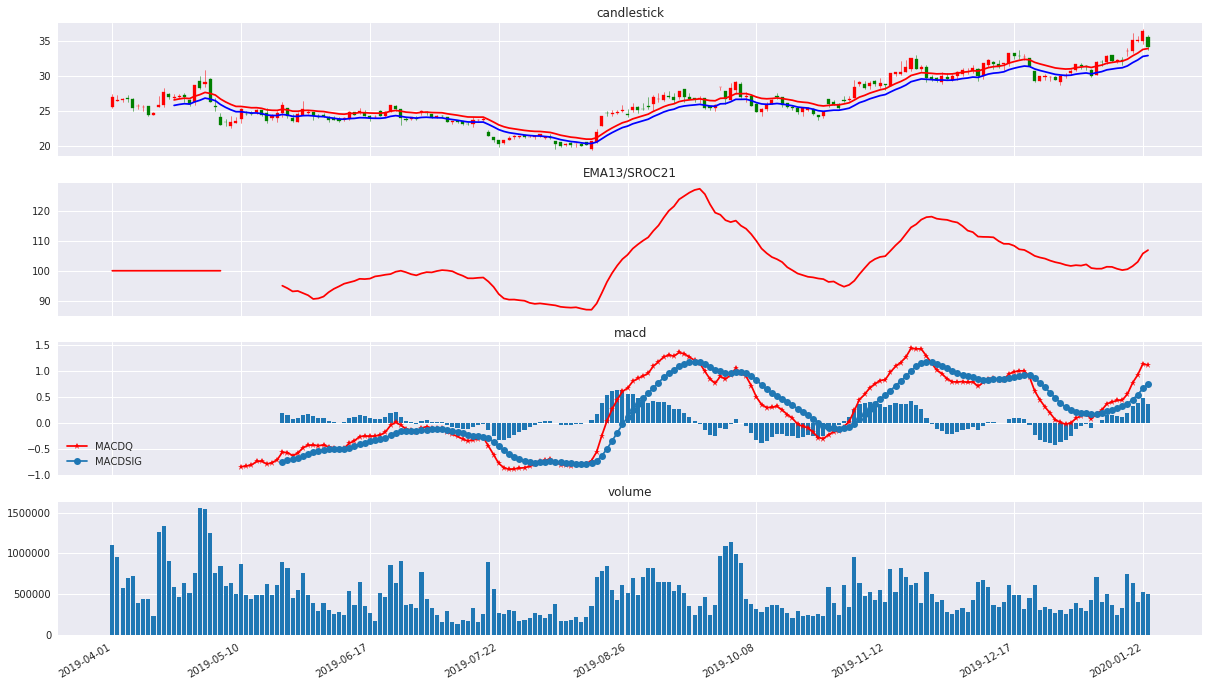

In [2]:
daydata = QA.QA_fetch_stock_day_adv('000977','2019-04-01','2020-01-25')

#MINMACACalculate(mindata.data)
#MINMACDPLOT(mindata.data,index,formate)
MACACalculate(daydata.data)
MACDPLOT(daydata.data)

In [21]:
sample = daydata.data
sample.close[np.argmax(sample.volume)[0]][0]
index = np.argmax(sample.volume)[0]


In [35]:
import datetime
import smtplib
from email.mime.text import MIMEText
import QUANTAXIS as QA

try:
    assert QA.__version__ >= '1.1.0'
except AssertionError:
    print('pip install QUANTAXIS >= 1.1.0 请升级QUANTAXIS后再运行此示例')
    import QUANTAXIS as QA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import abupy
from abupy import ABuRegUtil
from concurrent.futures import ThreadPoolExecutor
from functools import reduce
import warnings

read_dictionary = np.load('/home/mildone/Project/quanaly/liutong.npy', allow_pickle=True).item()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtk
import mpl_finance as mpf
import matplotlib.dates as mpd
import quant.Util as uti
import datetime

N = 5
ND = 3
def DROC(sample,N=3):
    quD = []
    size = sample.close.shape[0]
    for i in range(size):
        if(i>N):
            quD.append(((sample.cl[i]+sample.cl[i-1]+sample.cl[i-2])/(sample.hl[i]+sample.hl[i-1]+sample.hl[i-2]))*100)
        else:
            quD.append(None)
    sample['quD']=quD
    return sample

def kdj(sample):

    sample['EMA13'] = QA.EMA(sample.close, 13)
    sample['VolumeEMA'] = QA.EMA(sample.volume, 5)
    from abupy import pd_rolling_max
    from abupy import pd_expanding_max

    sample['nhigh'] = pd_rolling_max(sample.high, window=N)
    #expanmax = pd_expanding_max(sample.close)
    #sample['nhigh'].fillna(value=expanmax, inplace=True)

    from abupy import pd_rolling_min, pd_expanding_min
    sample['nlow'] = pd_rolling_min(sample.low, window=N)
    #expanmin = pd_expanding_min(sample.close)
    #sample['nlow'].fillna(value=expanmin, inplace=True)
    sample['quK']=((sample.close-sample.nlow)/(sample.nhigh-sample.nlow))*100
    sample['cl'] = sample.close - sample.nlow
    sample['hl'] = sample.nhigh - sample.nlow
    DROC(sample,ND)

    return sample



def MINcandlestruct(sample, index, timeFrmate):
    quotes = []
    pydate_array = sample.index.get_level_values(index).to_pydatetime()
    date_only_array = np.vectorize(lambda s: s.strftime(timeFrmate))(pydate_array)
    # date_only_series = pd.Series(date_only_array)
    N = sample.index.get_level_values(index).shape[0]
    ind = np.arange(N)
    for i in range(len(sample)):
        li = []
        # datet=datetime.datetime.strptime(sample.index.get_level_values('date'),'%Y%m%d')   #字符串日期转换成日期格式
        # datef=mpd.date2num(datetime.datetime.strptime(date_only_array[i],'%Y-%m-%d'))
        datef = ind[i]  # 日期转换成float days
        open_p = sample.open[i]
        close_p = sample.close[i]
        high_p = sample.high[i]
        low_p = sample.low[i]
        li = [datef, open_p, close_p, high_p, low_p]
        t = tuple(li)
        quotes.append(t)
    return quotes


def kdjPlot(sample, index, formate):
    quotes = MINcandlestruct(sample, index, formate)
    N = sample.index.get_level_values(index).shape[0]
    ind = np.arange(N)

    def format_date(x, pos=None):
        thisind = np.clip(int(x + 0.5), 0, N - 1)
        return sample.index.get_level_values(index)[thisind].strftime(formate)

    fig = plt.figure()
    #fig.set_size_inches(20.5, 12.5)
    # plt.xlabel('Trading Day')
    # plt.ylabel('MACD EMA')
    # ax2 = fig.add_subplot(6, 1, 1)
    ax2 = fig.add_subplot(2, 1, 1)
    ax2.set_title("candlestick", fontsize='xx-large', fontweight='bold')

    # fig,ax=plt.subplots()
    # mpf.candlestick_ochl(ax2,quotes,width=0.2,colorup='r',colordown='g',alpha=1.0)
    # ax2.xaxis_date()
    # plt.setp(plt.gca().get_xticklabels(),rotation=30)
    # ax2.plot(ind,sample.close,'b-',marker='*')
    mpf.candlestick_ochl(ax2, quotes, width=0.6, colorup='r', colordown='g', alpha=1.0)
    #va = sorted(list(sample.volume))
    #vmean = np.mean(sample.volume)
    '''
    for i in range(N):
        if(sample.volume[i]>vmean and sample.vchange[i]>1):
            ax2.axhline(y=sample.close[i],ls='--',color='green')
            ax2.text(N / 2,sample.close[i] ,
            str(sample.close[i]),
            fontdict={'size': '12', 'color': 'b'})
    '''

    ax2.plot(ind, sample.EMA13, 'r-')
    #temp = sample
    #ax2.axhline(y=sample.close[np.argmax(sample.volume[-180:])[0]][0], ls='--', color='red')
    #ax2.text(N / 2,sample.close[np.argmax(sample.volume[-180:])[0]][0] ,
            # "180 days press",
            # fontdict={'size': '12', 'color': 'b'})
    #for i in range(4):
        #temp.drop(index=np.argmax(temp.volume)[0])
        #ax2.axhline(y=sample.close[np.argmax(temp.volume)[0]][0],ls='--',color='red')
    # ax2.plot(ind,sample.EMA5,'yellow')
    # ax2.plot(ind,sample.EMA20,'green')
    # ax2.plot(ind,sample.EMA30,'purple')
    # ax2.plot(ind,sample.nhigh)
    # ax2.plot(ind,sample.nlow)
    # ax2.fill_between(ind,sample.EMA13,color='blue',alpha=0.08)

    ax2.text(N / 2, pd.DataFrame.max(sample.high), "EMA13 tells the trend",
             fontdict={'size': '12', 'color': 'b'})
    ax2.xaxis.set_major_formatter(mtk.FuncFormatter(format_date))
    # ax2.set_xticklabels(sample.index.get_level_values(index)[::3])
    ax2.grid(True)
    # t.legend()
    fig.autofmt_xdate()



    ax5 = fig.add_subplot(2, 1, 2, sharex=ax2)
    ax5.set_title('kdj', fontsize='xx-large', fontweight='bold')
    ax5.text(N / 2, pd.DataFrame.max(sample.volume),
             "kdj, quK / quD buy, quk \ quD sell",
             fontdict={'size': '12', 'color': 'b'})
    ax5.grid(True, which='minor')
    #bar_red = np.where(sample.close>sample.open, sample.volume, 0)
    #bar_green = np.where(sample.close<=sample.open, sample.volume,0)
    #ax5.bar(ind, bar_red,color='red')
    #ax5.bar(ind,bar_green,color='green')
    ax5.plot(ind,sample.quK,'r-')
    ax5.plot(ind,sample.quD,'g-')
    ax5.xaxis.set_major_formatter(mtk.FuncFormatter(format_date))
    fig.autofmt_xdate()

    plt.show()
    plt.close()





def volBreakANA(code):
    cur = datetime.datetime.now()
    if (str(cur.month) != '10' or str(cur.month) != '11' or str(cur.month) != '12'):
        month = '0' + str(cur.month)
    endtime = str(cur.year) + '-' + month + '-' + str(cur.day)
    print(endtime)
    data = QA.QA_fetch_stock_day_adv(code, '2019-12-01', endtime)
    sample = data.data

    kdj(sample)
    print(sample[-20:])
    #kdjPlot(sample,uti.dayindex,uti.dayformate)


if __name__ == "__main__":
    volBreakANA('600745')





2020-03-1
                     open    high     low   close    volume      amount  \
date       code                                                           
2020-02-03 600745  112.50  115.30  112.50  112.50  177654.0  2.0018e+09   
2020-02-04 600745  112.53  122.87  112.53  122.20  238902.0  2.8429e+09   
2020-02-05 600745  122.47  125.41  117.00  118.00  288793.0  3.5045e+09   
2020-02-06 600745  115.49  119.90  115.40  118.30  206430.0  2.4292e+09   
2020-02-07 600745  116.67  124.90  116.65  122.10  216102.0  2.6129e+09   
2020-02-10 600745  122.00  122.02  114.27  117.56  217192.0  2.5515e+09   
2020-02-11 600745  119.00  123.00  119.00  121.00  186470.0  2.2552e+09   
2020-02-12 600745  118.87  121.80  118.01  121.40  163327.0  1.9639e+09   
2020-02-13 600745  124.50  132.20  121.59  126.98  308422.0  3.9143e+09   
2020-02-14 600745  125.88  129.20  118.67  122.08  341301.0  4.2289e+09   
2020-02-17 600745  124.00  124.47  120.97  124.46  236659.0  2.9161e+09   
2020-02-18 6007

In [374]:
import datetime
cur = datetime.datetime.now()
endtime = str(cur.year)+'-'+str(cur.month)+'-'+str(cur.day)
codelist3 = QA.QA_fetch_stock_block_adv().get_block('云计算').code[:]
codelist1 = QA.QA_fetch_stock_block_adv().get_block('华为概念').code[:]
codelist2 = QA.QA_fetch_stock_block_adv().get_block('5G概念').code[:]
codelist4 = QA.QA_fetch_stock_block_adv().get_block('国产软件').code[:]
codelist1.extend(codelist2)
codelist1.extend(codelist3)
codelist1.extend(codelist4)
codelist = list(set(codelist1))
data = loadLocalData(codelist,'2019-08-01',endtime)
data = data.to_qfq()
data.select_code('000977')


QUANTAXIS>> load data from local DB
load data from local DB


In [ ]:
kdj = QA.QA_indicator_KDJ(sample)
plt.plot(sample.index.get_level_values('date'),kdj.)

In [72]:

def MINMACACalculate(sample):
    sample['EMA12']=QA.EMA(sample.close,12)
    sample['EMA26']=QA.EMA(sample.close,26)
    sample['MACDQ']=sample['EMA12']-sample['EMA26']
    sample['MACDSIG']=QA.EMA(sample['MACDQ'],9)
    sample['MACDBlock']=sample['MACDQ']-sample['MACDSIG']
    return sample
def MINcandlestruct(sample,index,timeFrmate):
    import matplotlib.dates as mpd
    quotes=[]
    pydate_array = sample.index.get_level_values(index).to_pydatetime()
    date_only_array = np.vectorize(lambda s: s.strftime(timeFrmate))(pydate_array )
#date_only_series = pd.Series(date_only_array)
    N=sample.index.get_level_values(index).shape[0]
    ind = np.arange(N)
    for i in range(len(sample)):
        li=[]
    #datet=datetime.datetime.strptime(sample.index.get_level_values('date'),'%Y%m%d')   #字符串日期转换成日期格式
        #datef=mpd.date2num(datetime.datetime.strptime(date_only_array[i],'%Y-%m-%d')) 
        datef=ind[i]#日期转换成float days
        open_p=sample.open[i]
        close_p=sample.close[i]
        high_p=sample.high[i]
        low_p=sample.low[i]
        li=[datef,open_p,close_p,high_p,low_p]
        t=tuple(li)
        quotes.append(t)
    return quotes

def MINMACDPLOT(sample,index,formate):
    quotes = MINcandlestruct(sample,index,formate)
    N=sample.index.get_level_values(index).shape[0]
    ind = np.arange(N)
    def format_date(x, pos=None):
        thisind = np.clip(int(x+0.5), 0, N-1)
        return sample.index.get_level_values(index)[thisind].strftime(formate)
    fig = plt.figure()
    fig.set_size_inches(20.5,12.5)
    #plt.xlabel('Trading Day')
    #plt.ylabel('MACD EMA')
    ax2 = fig.add_subplot(3,1,1)
    ax2.set_title("candlestick")
  
    
    #fig,ax=plt.subplots()
    #mpf.candlestick_ochl(ax2,quotes,width=0.2,colorup='r',colordown='g',alpha=1.0)
    #ax2.xaxis_date()
    #plt.setp(plt.gca().get_xticklabels(),rotation=30)
    #ax2.plot(ind,sample.close,'b-',marker='*')
    mpf.candlestick_ochl(ax2,quotes,width=0.6,colorup='r',colordown='g',alpha=1.0)
    ax2.xaxis.set_major_formatter(mtk.FuncFormatter(format_date))
    #ax2.set_xticklabels(sample.index.get_level_values(index)[::3])
    ax2.grid(True)
    #t.legend()
    fig.autofmt_xdate()
    
    
    ax3 = fig.add_subplot(3,1,3,sharex=ax2)
    ax3.set_title("volume")
    #ax1 = ax2.twinx()   #not working like it's 
    ax3.bar(ind,sample.volume)
    ax3.grid(True)
    ax3.xaxis.set_major_formatter(mtk.FuncFormatter(format_date))
    fig.autofmt_xdate()
    
    ax1 = fig.add_subplot(3,1,2,sharex=ax2)
    ax1.set_title('macd')
    ax1.grid(True)
    ax1.plot(ind,sample.MACDQ,'r-',marker='*')
    ax1.plot(ind,sample.MACDSIG)
    ax1.bar(ind,sample.MACDBlock)
    
    ax1.xaxis.set_major_formatter(mtk.FuncFormatter(format_date))
    #ax2.set_yticks(np.linspace(ax2.get_yticks()[0], ax2.get_yticks()[-1], len(ax1.get_yticks())))
    fig.autofmt_xdate()
    
    



    import random
    for i in range(sample.shape[0]):
        if(sample.MACDBlock[i-1]<0 and sample.MACDBlock[i]>=0):
            ax1.annotate('buy %s'%sample.index.get_level_values('date')[i].strftime('%D'),
                         xy=(i,sample.MACDBlock[i]),xytext=(i, sample.MACDBlock[i]+random.uniform(0.5,1.5)),
            xycoords='data',
            arrowprops=dict(facecolor='red', shrink=0.05))
        elif(sample.MACDBlock[i-1]>=0 and sample.MACDBlock[i]<0):
            ax1.annotate('sell %s'%sample.index.get_level_values('date')[i].strftime('%D'),
                         xy=(i,sample.MACDBlock[i]),xytext=(i, sample.MACDBlock[i]+random.uniform(0.5,1.5)),
            xycoords='data',
            arrowprops=dict(facecolor='green', shrink=0.05))
    plt.legend()
    
    
    code = sample.index.get_level_values('code')[0]
    
    #plt.savefig('/home/mildone/monitor/'+'Trend'+code+'.png')
    plt.show()
    plt.close()

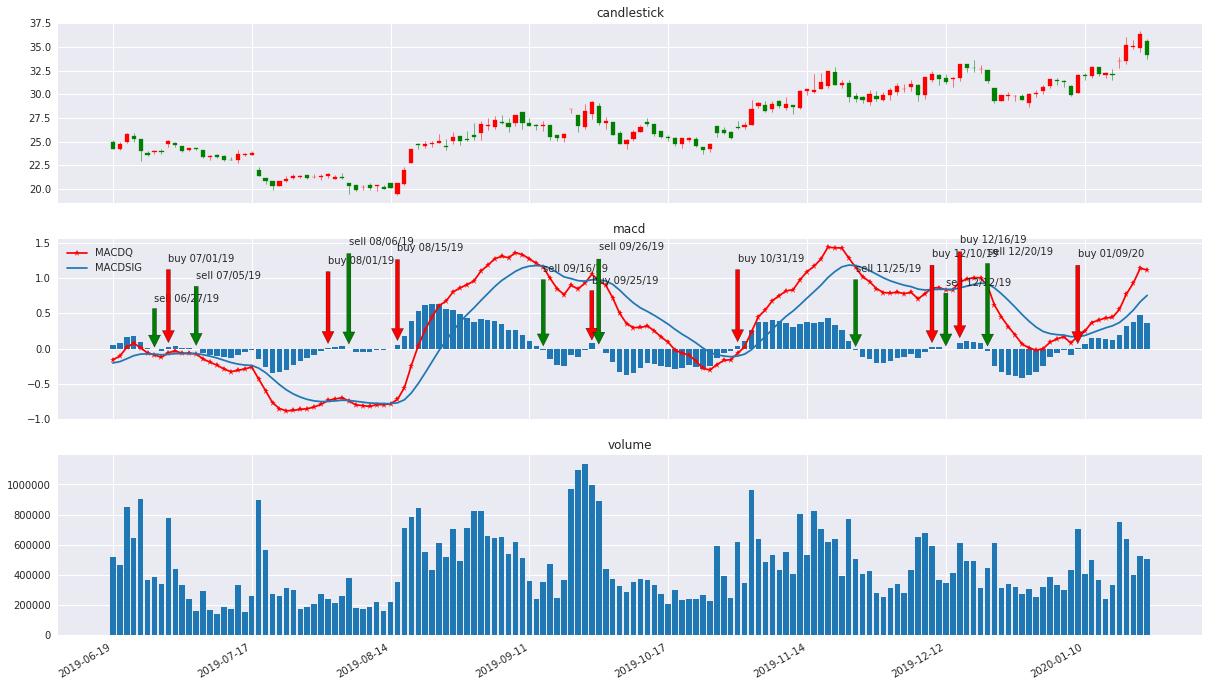

In [73]:
mindata = QA.QA_fetch_stock_min_adv('000977','2019-12-01','2020-01-25',frequence='30min')
index = 'datetime'
formate = '%Y-%m-%dT%H:%M:%S'
dayindex = 'date'
dayformate = '%Y-%m-%d'
daydata = QA.QA_fetch_stock_day_adv('000977','2019-01-01','2020-01-25')

#MINMACACalculate(mindata.data)
#MINMACDPLOT(mindata.data,index,formate)
MINMACACalculate(daydata.data)
MINMACDPLOT(daydata.data[-150:],dayindex,dayformate)


In [707]:

def pivotIndicator(data,index,formate):
    #prepare data
    sample=MACACalculate(data)[-90:]
    #candlestick prepare
    quotes = MINcandlestruct(sample,index,formate)
    N=sample.index.get_level_values(index).shape[0]
    #formate timeindex
    ind = np.arange(N)
    def format_date(x, pos=None):
        thisind = np.clip(int(x+0.5), 0, N-1)
        return sample.index.get_level_values(index)[thisind].strftime(formate)
    fig = plt.figure()
    fig.set_size_inches(20.5,12.5)
    #plt.xlabel('Trading Day')
    #plt.ylabel('MACD EMA')
    ax2 = fig.add_subplot(3,1,1)
    ax2.set_title("candlestick with EMA13")
    ax2.plot(ind,sample.EMA13)
    mpf.candlestick_ochl(ax2,quotes,width=0.6,colorup='r',colordown='g',alpha=1.0)
    ax2.xaxis.set_major_formatter(mtk.FuncFormatter(format_date))
    
    ax2.grid(True,which='minor')
    #t.legend()
    fig.autofmt_xdate()
    
    ax3 = fig.add_subplot(3,1,2,sharex=ax2)
    ax3.set_title("OPTIMISM")
    #ax1 = ax2.twinx()   #not working like it's 
    ax3.bar(ind,sample.optimism)
    ax3.grid(True,which='minor')
    ax3.xaxis.set_major_formatter(mtk.FuncFormatter(format_date))
    fig.autofmt_xdate()
    
    ax1 = fig.add_subplot(3,1,3,sharex=ax2)
    ax1.set_title('PESSMIST')
    ax1.grid(True,which='minor')
    ax1.bar(ind,sample.pessmist)
    ax1.xaxis.set_major_formatter(mtk.FuncFormatter(format_date))
    fig.autofmt_xdate()
    plt.legend()
    
    
    #code = sample.index.get_level_values('code')[0]
    
    #plt.savefig('/home/mildone/monitor/'+'Trend'+code+'.png')
    plt.show()
    plt.close()
    

QUANTAXIS>> No handles with labels found to put in legend.
No handles with labels found to put in legend.


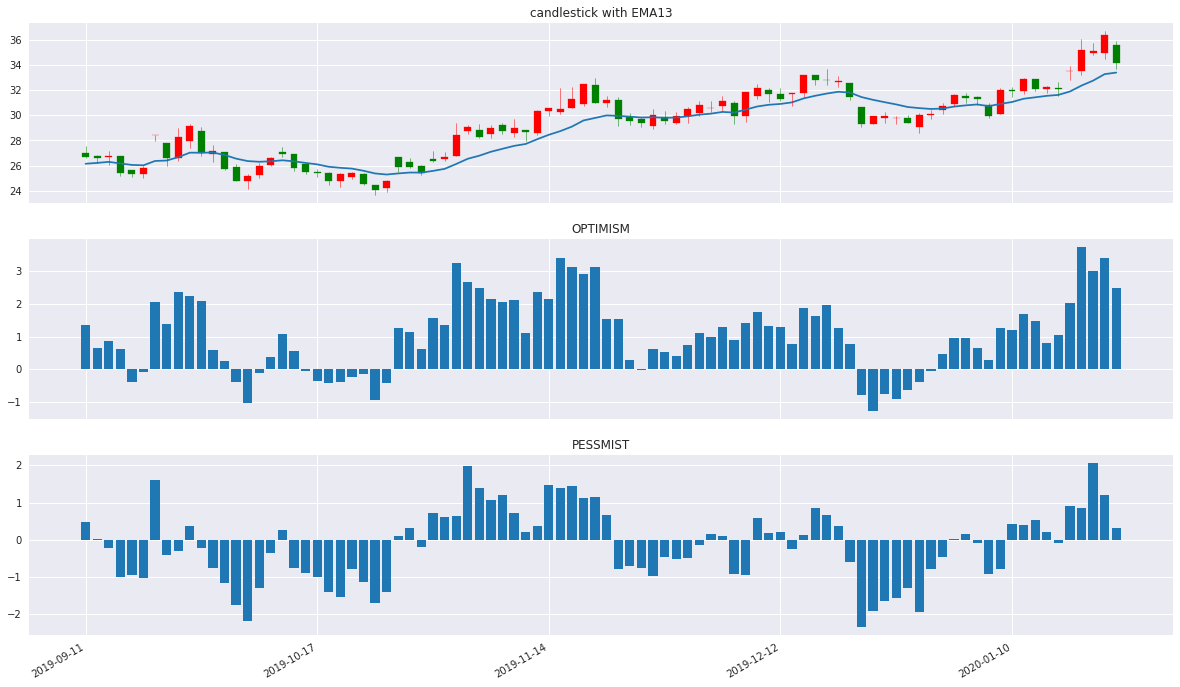

In [708]:
df = QA.QA_fetch_stock_day_adv('000977','2018-01-01','2020-01-25')
pivotIndicator(df.data,dayindex,dayformate)

In [709]:
def resample(df):
    # https://pandas-docs.github.io/pandas-docs-travis/timeseries.html#offset-aliases
    # 周 W、月 M、季度 Q、10天 10D、2周 2W
    period = 'W'

    weekly_df = df.resample(period, how='last')
    weekly_df['open'] = df['open'].resample(period, how='first')
    weekly_df['high'] = df['high'].resample(period, how='max')
    weekly_df['low'] = df['low'].resample(period, how='min')
    weekly_df['close'] = df['close'].resample(period, how='last')
    weekly_df['volume'] = df['volume'].resample(period, how='sum')
    weekly_df['amount'] = df['amount'].resample(period, how='sum')
    # 去除空的数据（没有交易的周）
    weekly_df = weekly_df[weekly_df.instrument.notnull()]
    weekly_df.reset_index(inplace=True)
    return weekly_df

def weekDF(df):
    df.reset_index(inplace=True)
    df.drop(['code'],axis=1,inplace=True)
    df['date'] = pd.to_datetime(sda['date'])
    df.set_index("date", inplace=True)
    period = 'W'
    weekly_df = df.resample(period, how='last')
    weekly_df['open'] = df['open'].resample(period, how='first')
    weekly_df['high'] = df['high'].resample(period, how='max')
    weekly_df['low'] = df['low'].resample(period, how='min')
    weekly_df['close'] = df['close'].resample(period, how='last')
    weekly_df['volume'] = df['volume'].resample(period, how='sum')
    weekly_df['amount'] = df['amount'].resample(period, how='sum')
    weekly_df.reset_index('date',inplace=True)
    return weekly_df


wd = weekDF(sda)
sample=wd

def weektrend(sample):
    sample['EMA12']= pd.Series.ewm(sample.close, span=12, min_periods=12 - 1, adjust=True).mean()
    sample['EMA26']= pd.Series.ewm(sample.close, span=26, min_periods=26 - 1, adjust=True).mean()
    sample['MACDQ']= sample['EMA12']-sample['EMA26']
    sample['MACDSIG']=pd.Series.ewm(sample.MACDQ, span=9, min_periods=9 - 1, adjust=True).mean()
    sample['MACDBlock']=sample['MACDQ']-sample['MACDSIG']
    return sample

weektrend(sample)
import matplotlib.dates as mpd
quotes=[]

N=sample.shape[0]
ind = np.arange(N)
for i in range(len(sample)):
    li=[]
    datef=ind[i]#日期转换成float days
    open_p=sample.open[i]
    close_p=sample.close[i]
    high_p=sample.high[i]
    low_p=sample.low[i]
    li=[datef,open_p,close_p,high_p,low_p]
    t=tuple(li)
    quotes.append(t)
def format_date(x, pos=None):
    thisind = np.clip(int(x+0.5), 0, N-1)
    return sample.date[thisind].strftime('%Y-%m-%d')
fig = plt.figure()
fig.set_size_inches(30.5,20.5)

ax2 = fig.add_subplot(2,1,1)
ax2.set_title("weekly candlestick",fontsize='xx-large',fontweight='bold')

mpf.candlestick_ochl(ax2,quotes,width=0.6,colorup='r',colordown='g',alpha=1.0)
ax2.xaxis.set_major_formatter(mtk.FuncFormatter(format_date))
ax2.grid(True)
    #t.legend()
fig.autofmt_xdate()


ax1 = fig.add_subplot(2,1,2,sharex=ax2)
ax1.set_title('weekly macd',fontsize='xx-large',fontweight='bold')
ax1.grid(True)
ax1.plot(ind,sample.MACDQ,'r-',marker='*')
ax1.plot(ind,sample.MACDSIG,'o-')
ax1.bar(ind,sample.MACDBlock)
ax1.xaxis.set_major_formatter(mtk.FuncFormatter(format_date))
    #ax2.set_yticks(np.linspace(ax2.get_yticks()[0], ax2.get_yticks()[-1], len(ax1.get_yticks())))
fig.autofmt_xdate()
plt.legend()
fig.show()

KeyError: "['code'] not found in axis"

In [380]:
def gitAction(candidate):
    from git import Repo
    r = Repo('/home/mildone/monitor')
    commitfile = [r'/home/mildone/monitor/result.log',r'/home/mildone/monitor/data.csv']
    
    prefix = '/home/mildone/monitor/'
    if(len(candidate)>0):
        for i in range(len(candidate)):          
            generateplot(candidate[i])
            pltfile = prefix+'Trend'+candidate[i]+'.png'
            commitfile.append(pltfile)
    #r.index.add(commitfile)
    #cur = datetime.datetime.now()
    #msg = str(cur.year)+'-'+str(cur.month)+'-'+str(cur.day)+' commit'
    #r.index.commit(msg)
    #r.remote().push('master')


QUANTAXIS>> load data from local DB
load data from local DB


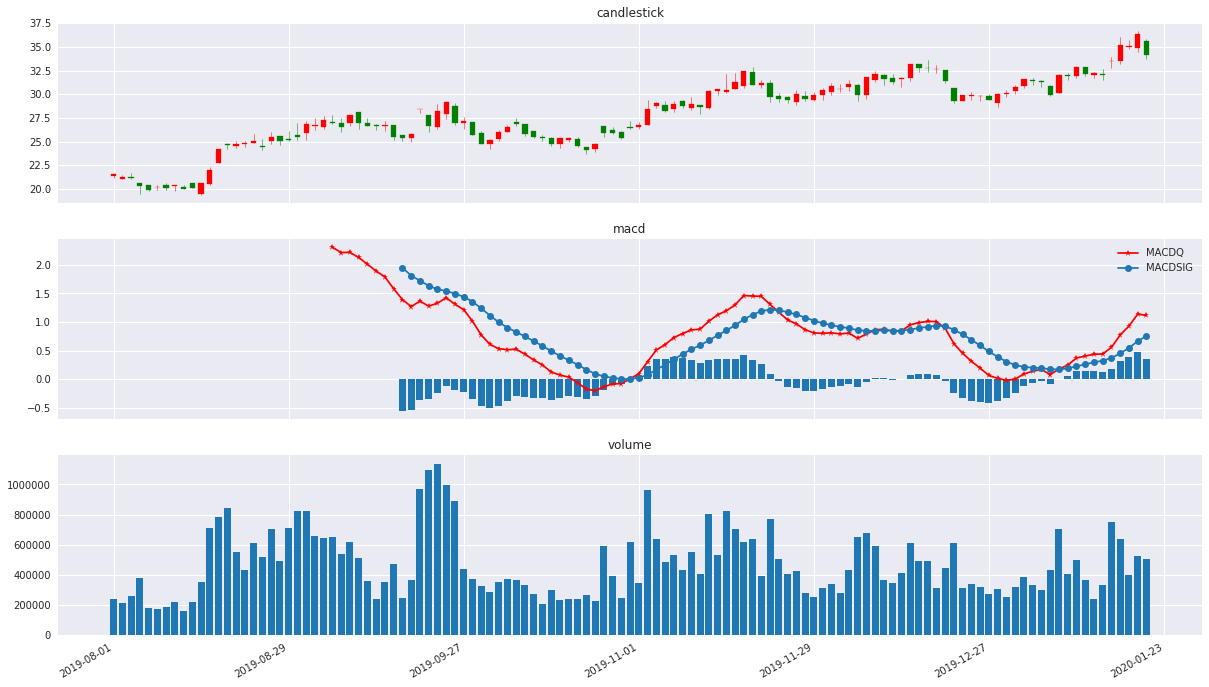

QUANTAXIS>> load data from local DB
load data from local DB


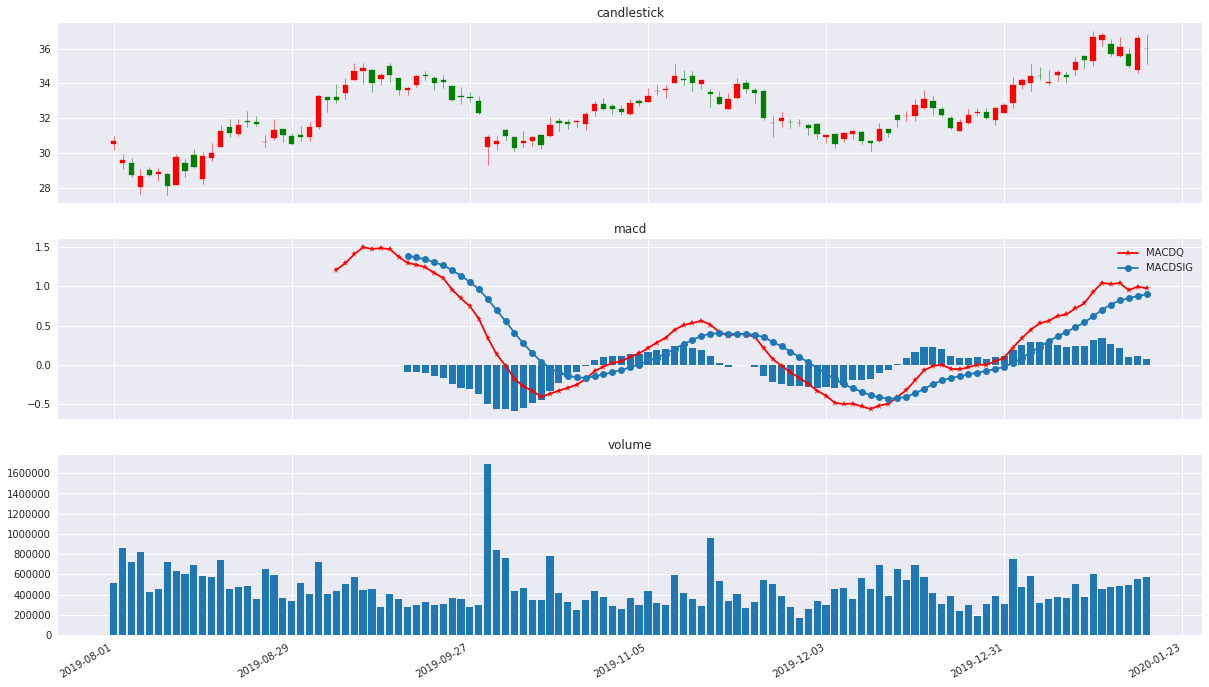

In [381]:
gitAction(['000977','002415'])

In [191]:
def candlePlot(sample):
    sample.plot()

In [192]:
candlePlot(sample)

QUANTAXIS>> The Pic has been saved to your path: ./QA_stock_day_None_qfq.html
The Pic has been saved to your path: ./QA_stock_day_None_qfq.html


In [181]:
sample

QUANTAXIS>> The Pic has been saved to your path: ./QA_stock_day_None_bfq.html
The Pic has been saved to your path: ./QA_stock_day_None_bfq.html


In [25]:
test = pd.DataFrame(pd.read_csv('/home/mildone/monitor/data.csv'))

In [35]:
data.data.to_csv('/home/mildone/data.csv')
test = pd.DataFrame(pd.read_csv('/home/mildone/monitor/data.csv'))

In [57]:
test[test.code=='611']

,date,code,open,high,low,close,volume,amount,preclose,adj


****************************************************************************************************
loading data
****************************************************************************************************
init account


QUANTAXIS>> load data from local DB
load data from local DB


****************************************************************************************************
prepare data for back test
Index(['000008', '000016', '000027', '000050', '000058', '000100', '000156',
       '000158', '000410', '000430',
       ...
       '601933', '603000', '603019', '603258', '603386', '603535', '603587',
       '603776', '603881', '603888'],
      dtype='object', name='code', length=171)
Index(['000008', '000016', '000027', '000050', '000058', '000100', '000156',
       '000158', '000410', '000430',
       ...
       '601933', '603000', '603019', '603258', '603386', '603535', '603587',
       '603776', '603881', '603888'],
      dtype='object', name='code', length=171)
Index(['000008', '000016', '000027', '000050', '000058', '000100', '000156',
       '000158', '000410', '000430',
       ...
       '601933', '603000', '603019', '603258', '603386', '603535', '603587',
       '603776', '603881', '603888'],
      dtype='object', name='code', length=171)
Index(['000

      dtype='object', name='code', length=171)
Index(['000008', '000016', '000027', '000050', '000058', '000100', '000156',
       '000158', '000410', '000430',
       ...
       '601933', '603000', '603019', '603258', '603386', '603535', '603587',
       '603776', '603881', '603888'],
      dtype='object', name='code', length=171)
Index(['000008', '000016', '000027', '000050', '000058', '000100', '000156',
       '000158', '000410', '000430',
       ...
       '601933', '603000', '603019', '603258', '603386', '603535', '603587',
       '603776', '603881', '603888'],
      dtype='object', name='code', length=171)
Index(['000008', '000016', '000027', '000050', '000058', '000100', '000156',
       '000158', '000410', '000430',
       ...
       '601933', '603000', '603019', '603258', '603386', '603535', '603587',
       '603776', '603881', '603888'],
      dtype='object', name='code', length=171)
Index(['000008', '000016', '000027', '000050', '000058', '000100', '000156',
       '000158'

      dtype='object', name='code', length=171)
Index(['000008', '000016', '000027', '000050', '000058', '000100', '000156',
       '000158', '000410', '000430',
       ...
       '601933', '603000', '603019', '603258', '603386', '603535', '603587',
       '603776', '603881', '603888'],
      dtype='object', name='code', length=171)
Index(['000008', '000016', '000027', '000050', '000058', '000100', '000156',
       '000158', '000410', '000430',
       ...
       '601933', '603000', '603019', '603258', '603386', '603535', '603587',
       '603776', '603881', '603888'],
      dtype='object', name='code', length=171)
Index(['000008', '000016', '000027', '000050', '000058', '000100', '000156',
       '000158', '000410', '000430',
       ...
       '601933', '603000', '603019', '603258', '603386', '603535', '603587',
       '603776', '603881', '603888'],
      dtype='object', name='code', length=171)
Index(['000008', '000016', '000027', '000050', '000058', '000100', '000156',
       '000158'

      dtype='object', name='code', length=171)
Index(['000008', '000016', '000027', '000050', '000058', '000100', '000156',
       '000158', '000410', '000430',
       ...
       '601933', '603000', '603019', '603258', '603386', '603535', '603587',
       '603776', '603881', '603888'],
      dtype='object', name='code', length=171)
Index(['000008', '000016', '000027', '000050', '000058', '000100', '000156',
       '000158', '000410', '000430',
       ...
       '601933', '603000', '603019', '603258', '603386', '603535', '603587',
       '603776', '603881', '603888'],
      dtype='object', name='code', length=171)
Index(['000008', '000016', '000027', '000050', '000058', '000100', '000156',
       '000158', '000410', '000430',
       ...
       '601933', '603000', '603019', '603258', '603386', '603535', '603587',
       '603776', '603881', '603888'],
      dtype='object', name='code', length=171)
Index(['000008', '000016', '000027', '000050', '000058', '000100', '000156',
       '000158'

      dtype='object', name='code', length=171)
Index(['000008', '000016', '000027', '000050', '000058', '000100', '000156',
       '000158', '000410', '000430',
       ...
       '601933', '603000', '603019', '603258', '603386', '603535', '603587',
       '603776', '603881', '603888'],
      dtype='object', name='code', length=171)
Index(['000008', '000016', '000027', '000050', '000058', '000100', '000156',
       '000158', '000410', '000430',
       ...
       '601933', '603000', '603019', '603258', '603386', '603535', '603587',
       '603776', '603881', '603888'],
      dtype='object', name='code', length=171)
Index(['000008', '000016', '000027', '000050', '000058', '000100', '000156',
       '000158', '000410', '000430',
       ...
       '601933', '603000', '603019', '603258', '603386', '603535', '603587',
       '603776', '603881', '603888'],
      dtype='object', name='code', length=171)
Index(['000008', '000016', '000027', '000050', '000058', '000100', '000156',
       '000158'

      dtype='object', name='code', length=171)
Index(['000008', '000016', '000027', '000050', '000058', '000100', '000156',
       '000158', '000410', '000430',
       ...
       '601933', '603000', '603019', '603258', '603386', '603535', '603587',
       '603776', '603881', '603888'],
      dtype='object', name='code', length=171)
Index(['000008', '000016', '000027', '000050', '000058', '000100', '000156',
       '000158', '000410', '000430',
       ...
       '601933', '603000', '603019', '603258', '603386', '603535', '603587',
       '603776', '603881', '603888'],
      dtype='object', name='code', length=171)
Index(['000008', '000016', '000027', '000050', '000058', '000100', '000156',
       '000158', '000410', '000430',
       ...
       '601933', '603000', '603019', '603258', '603386', '603535', '603587',
       '603776', '603881', '603888'],
      dtype='object', name='code', length=171)
Index(['000008', '000016', '000027', '000050', '000058', '000100', '000156',
       '000158'

****************************************************************************************************
2019-03-08 00:00:00 buy 600978
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!receive deal
****************************************************************************************************
2019-03-08 00:00:00 buy 601116
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!receive deal
****************************************************************************************************
2019-03-08 00:00:00 buy 601929
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!receive deal
****************************************************************************************************
2019-03-08 00:00:00 buy 603258
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-03-11 00:00:00 sell 300253
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!receive deal
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-03-12 00:00:00 sell 60063

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-07-05 00:00:00 sell 300178
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!receive deal
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!receive deal
****************************************************************************************************
2019-07-17 00:00:00 buy 002170
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!receive deal
****************************************************************************************************
2019-07-17 00:00:00 buy 300071
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!receive deal
****************************************************************************************************
2019-07-17 00:00:00 buy 300274
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!receive deal
****************************************************************************************************
2019-07-17 00:00:00 buy 600476
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

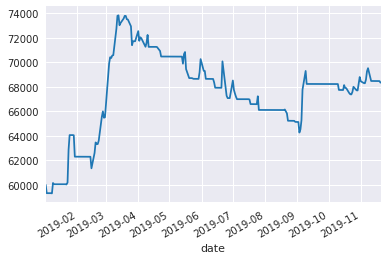

In [9]:
if __name__ == '__main__':
    print('*'*100)
    print('loading data')
    #stockes = getStocklist()
    #stockes = ['600797','000977']
    #data = loadLocalData(stockes,'2018-03-15',end_date = '2019-09-11')
    print('*'*100)
    print('init account')
    Account=QA.QA_Account(user_cookie='eric',portfolio_cookie='eric')
    Broker=QA.QA_BacktestBroker()
    Account.reset_assets(60000)
    Account.account_cookie='ECAP'
    #codelist=['600797','000977','601068','601069','000977']
    #云计算，华为，5G概念
    codelist3 = QA.QA_fetch_stock_block_adv().get_block('云计算').code[:]
    codelist1 = QA.QA_fetch_stock_block_adv().get_block('华为概念').code[:]
    codelist2 = QA.QA_fetch_stock_block_adv().get_block('5G概念').code[:]
    #codelist4 = QA.QA_fetch_stock_block_adv().get_block('国产软件').code[:]
    codelist1.extend(codelist2)
    codelist1.extend(codelist3)
    
    #
    clist3 = QA.QA_fetch_stock_block_adv().get_block('阿里概念').code[:]
    clist1 = QA.QA_fetch_stock_block_adv().get_block('腾讯概念').code[:]
    clist2 = QA.QA_fetch_stock_block_adv().get_block('小米概念').code[:]
    #codelist4 = QA.QA_fetch_stock_block_adv().get_block('国产软件').code[:]
    clist1.extend(clist2)
    clist1.extend(clist3)
    
    
    #codelist1.extend(codelist4)
    codelist = list(set(codelist1))
    #codelist = list(set(clist1))
    #data=QA.QA_fetch_stock_day_adv(codelist,'2018-01-01','2019-09-04')
    data = loadLocalData(codelist,'2014-01-01','2019-11-25')
    data=data.to_qfq()
    print('*'*100)
    print('prepare data for back test')
    
    
    
    ind=data.add_func(trendSingle3)
    #ind=data.add_func(MACACalculate)
    data_forbacktest=data.select_time('2019-01-01','2019-12-25')


    for items in data_forbacktest.panel_gen:
        for item in items.security_gen:
        
            daily_ind=ind.loc[item.index]
        #print(daily_ind)
            if (daily_ind.single.iloc[0] == 1):
                if((Account.cash_available-2000)/(2*item.open[0]) > 0):
                    order=Account.send_order(
                        code=item.code[0], 
                        time=item.date[0], 
                        amount=int((Account.cash_available-5000)/(2*item.open[0])), 
                    #amount = 2000,
                #amount=2000,
                        towards=QA.ORDER_DIRECTION.BUY, 
                        price=item.open[0], 
                        order_model=QA.ORDER_MODEL.CLOSE, 
                        amount_model=QA.AMOUNT_MODEL.BY_AMOUNT
                        )
                elif((Account.cash_available-2000)/(item.open[0]) > 0): 
                    order=Account.send_order(
                        code=item.code[0], 
                        time=item.date[0], 
                        amount=int((Account.cash_available-5000)/item.open[0]), 
                    #amount = 2000,
                #amount=2000,
                        towards=QA.ORDER_DIRECTION.BUY, 
                        price=item.open[0], 
                        order_model=QA.ORDER_MODEL.CLOSE, 
                        amount_model=QA.AMOUNT_MODEL.BY_AMOUNT
                        )
            #print(item.to_json()[0])
                if order: 
                #print('sending order '+'*'*60)
                    Broker.receive_order(QA.QA_Event(order=order,market_data=item))
            
            
                    trade_mes=Broker.query_orders(Account.account_cookie,'filled')
                    res=trade_mes.loc[order.account_cookie,order.realorder_id]
                    #print(trade_mes)
                    order.trade(res.trade_id,res.trade_price,res.trade_amount,res.trade_time)
                    print('*'*100)
                    print(str(item.date[0])+" buy "+item.code[0])
                #print (res)
            elif (daily_ind.single.iloc[0] == 3 ) :        
                if Account.sell_available.get(item.code[0], 0)>0:
                    print('>'*100)
                    print(str(item.date[0])+" sell "+ item.code[0])
                #print(int(Account.sell_available.get(item.code[0], 0)))
                    order=Account.send_order(
                        code=item.code[0], 
                        time=item.date[0], 
                        
                        
                        
                        
                        
                        amount=Account.sell_available.get(item.code[0], 0), 
                        towards=QA.ORDER_DIRECTION.SELL, 
                        price=item.close[0], 
                        order_model=QA.ORDER_MODEL.MARKET, 
                        amount_model=QA.AMOUNT_MODEL.BY_AMOUNT
                        )
                    if order: 
                        Broker.receive_order(QA.QA_Event(order=order,market_data=item))


                        trade_mes=Broker.query_orders(Account.account_cookie,'filled')
                        res=trade_mes.loc[order.account_cookie,order.realorder_id]
                        order.trade(res.trade_id,res.trade_price,res.trade_amount,res.trade_time)
                #print(res)
        Account.settle()
        
    print('*'*100)
    print('analyse account profit')
    Risk=QA.QA_Risk(Account)
    Risk.assets.plot()
    print(Risk.profit_construct) 


In [6]:
Account.history_table


,datetime,code,price,amount,cash,order_id,realorder_id,trade_id,account_cookie,commission,tax,message,frozen
0,2019-01-03 00:00:00,300123,5.07,4300,28193.5497,Order_2Ucg6Nh9,Order_2Ucg6Nh9,Trade_HJAfydT5,ECAP,5.4503,0.000,None,0
1,2019-01-08 00:00:00,000066,4.94,2300,16826.5497,Order_uvHDKklj,Order_uvHDKklj,Trade_ewFC2ZMW,ECAP,5.0000,0.000,None,0
2,2019-01-08 00:00:00,000836,4.17,1400,10983.5497,Order_UfD9hFJy,Order_UfD9hFJy,Trade_UejSD1as,ECAP,5.0000,0.000,None,0
3,2019-01-08 00:00:00,000948,7.71,300,8665.5497,Order_S7qRkbeW,Order_S7qRkbeW,Trade_xAVRZq1S,ECAP,5.0000,0.000,None,0
4,2019-01-08 00:00:00,002137,7.11,200,7238.5497,Order_TrwucXJ8,Order_TrwucXJ8,Trade_IdY9nF5f,ECAP,5.0000,0.000,None,0
5,2019-01-09 00:00:00,000948,7.76,-300,9559.2217,Order_i8OLy7BK,Order_i8OLy7BK,Trade_o52zgEeI,ECAP,5.0000,2.328,None,0
6,2019-01-09 00:00:00,002194,6.64,300,7562.2217,Order_9pI40uqd,Order_9pI40uqd,Trade_GAJBsf9O,ECAP,5.0000,0.000,None,0
7,2019-01-09 00:00:00,300319,6.19,200,6319.2217,Order_FuYmoNX8,Order_FuYmoNX8,Trade_mLpqMNfD,ECAP,5.0000,0.000,None,0
8,2019-01-10 00:00:00,000066,5.00,-2300,17802.7217,Order_YuE0624i,Order_YuE0624i,Trade_2dyYM0Km,ECAP,5.0000,11.500,None,0
9,2019-01-10 00:00:00,300123,5.24,-4300,40306.5567,Order_4EcDIBi6,Order_4EcDIBi6,Trade_Q4a5pCth,ECAP,5.6330,22.532,None,0


In [11]:
data = data.to_qfq()
init_change(data.data)
init_trend(data.data)
data.data

QUANTAXIS>> none support type for qfq Current type is: qfq
none support type for qfq Current type is: qfq


,,open,high,low,close,volume,amount,preclose,adj,change,amplitude,SR,trend,amountRatio
date,code,,,,,,,,,,,,,
2019-01-02,002241,6.8068,6.8759,6.7673,6.7969,8.1094e+04,5.5200e+07,NaN,0.9879,0.000,0.000,0.0029,1.9276,0.5325
2019-01-03,002241,6.7969,6.9056,6.6784,6.6882,1.4013e+05,9.5172e+07,6.7969,0.9879,-0.016,0.016,0.0051,1.9276,0.9180
2019-01-04,002241,6.5993,6.8167,6.5796,6.8068,1.9460e+05,1.3090e+08,6.6882,0.9879,0.018,0.033,0.0070,1.9276,1.2627
2019-01-07,002241,6.8661,6.9451,6.8068,6.9352,1.6366e+05,1.1296e+08,6.8068,0.9879,0.019,0.034,0.0059,1.9276,1.0896
2019-01-08,002241,6.9451,7.0439,6.8759,6.9846,1.3871e+05,9.6450e+07,6.9352,0.9879,0.007,0.020,0.0050,1.9276,0.9304
2019-01-09,002241,6.9846,7.0834,6.9352,6.9550,2.0704e+05,1.4561e+08,6.9846,0.9879,-0.004,0.024,0.0075,1.9276,1.4046
2019-01-10,002241,6.9747,7.0241,6.9155,6.9253,1.2819e+05,8.9382e+07,6.9550,0.9879,-0.004,0.021,0.0046,1.9276,0.8622
2019-01-11,002241,6.9155,7.0439,6.9155,6.9945,1.1940e+05,8.3374e+07,6.9253,0.9879,0.010,0.016,0.0043,2.0636,0.7246
2019-01-14,002241,6.9945,7.0439,6.9451,7.0143,1.2183e+05,8.5157e+07,6.9945,0.9879,0.003,0.018,0.0044,1.1932,0.8068


In [53]:
import datetime 

In [62]:
cur = datetime.datetime.now().strftime('%Y-%m-%d')

In [64]:
type(cur)

str

In [10]:
endtime = str(cur.year)+'-'+str(cur.month)+'-'+str(cur.day)
print('endtime is {}'.format(endtime))

endtime is 2019-12-19


In [ ]:
 if(1.5>df.iloc[i].amountRatio>1 and df.iloc[i].trend>1 and df.iloc[i].amplitude>0.05
           and 0.01<df.iloc[i].change<0.03 and df.iloc[i].SR <0.05 ):

In [4]:
import datetime
import smtplib
from email.mime.text import MIMEText
def sendmail():
    msg_from = 'skiping1982@163.com'  # 发送方邮箱
    passwd = 'jyn821014'  # 填入发送方邮箱的授权码(填入自己的授权码，相当于邮箱密码)
    msg_to = ['ynjiang@foxmail.com','skiping1982@163.com']  # 收件人邮箱

    subject = "INFO"  # 主题
    content = str(code)
# 生成一个MIMEText对象（还有一些其它参数）
# _text_:邮件内容
    msg = MIMEText(content)
# 放入邮件主题
    msg['Subject'] = subject
# 也可以这样传参
# msg['Subject'] = Header(subject, 'utf-8')
# 放入发件人
    msg['From'] = msg_from
# 放入收件人
    msg['To'] = msg_to
# msg['To'] = '发给你的邮件啊'
    try:
    # 通过ssl方式发送，服务器地址，端口
        s = smtplib.SMTP_SSL("smtp.163.com", 465)
    # 登录到邮箱
        s.login(msg_from, passwd)
    # 发送邮件：发送方，收件方，要发送的消息
        s.sendmail(msg_from, msg_to, msg.as_string())
        print('success sent')
    except s.SMTPException as e:
        print(e)
    finally:
        s.quit()
def analysis(endtime):
    codelist1 = QA.QA_fetch_stock_block_adv().get_block('华为概念').code[:]
    codelist2 = QA.QA_fetch_stock_block_adv().get_block('5G概念').code[:]
    codelist4 = QA.QA_fetch_stock_block_adv().get_block('国产软件').code[:]
    
    codelist1.extend(codelist2)
    codelist1.extend(codelist4)
    codelist=list(set(codelist1))
    data = loadLocalData(codelist,'2019-01-01',endtime)
    print('endtime is {}'.format(endtime))
    data=data.to_qfq()
    print('*'*100)
    print('prepare data for back test')
    
    
    select=[]
    for stock in codelist:
        try:
            QA.QA_util_log_info('dealting with {}'.format(stock))
            stockp = data.select_code(stock)
            if (ana(stockp.data)):
                select.append(stock)
        except:
            print()
            print('wrong with {}'.format(stock))
    return select
if __name__ == "__main__":
    cur = datetime.datetime.now()
    endtime = str(cur.year)+'-'+str(cur.month)+'-'+str(cur.day)
    #edtime='2019-12-30'
    candidate = analysis(endtime)
    print('>'*100)
    for item in candidate:
        print(item)


    


QUANTAXIS>> load data from local DB
load data from local DB


endtime is 2020-1-7
****************************************************************************************************
prepare data for back test


QUANTAXIS>> dealting with 300184
dealting with 300184
QUANTAXIS>> dealting with 002268
dealting with 002268
QUANTAXIS>> dealting with 300560
dealting with 300560
QUANTAXIS>> dealting with 300504
dealting with 300504
QUANTAXIS>> dealting with 300563
dealting with 300563
QUANTAXIS>> dealting with 300036
dealting with 300036
QUANTAXIS>> dealting with 002885
dealting with 002885
QUANTAXIS>> dealting with 002436
dealting with 002436
QUANTAXIS>> dealting with 002706
dealting with 002706
QUANTAXIS>> dealting with 002049
dealting with 002049
QUANTAXIS>> dealting with 300394
dealting with 300394
QUANTAXIS>> dealting with 300502
dealting with 300502
QUANTAXIS>> dealting with 300578
dealting with 300578
QUANTAXIS>> dealting with 600105
dealting with 600105
QUANTAXIS>> dealting with 603383
dealting with 603383
QUANTAXIS>> dealting with 002777
dealting with 002777
QUANTAXIS>> dealting with 002313
dealting with 002313
QUANTAXIS>> dealting with 600289
dealting with 600289
QUANTAXIS>> dealting with 00

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
002152
300166


In [18]:
def sendmail(code):
    msg_from = 'skiping1982@163.com'  # 发送方邮箱
    passwd = 'jyn821014'  # 填入发送方邮箱的授权码(填入自己的授权码，相当于邮箱密码)
    msg_to = ['ynjiang@foxmail.com','skiping1982@163.com']  # 收件人邮箱

    subject = "INFO"  # 主题
    content = str(code)
# 生成一个MIMEText对象（还有一些其它参数）
# _text_:邮件内容
    msg = MIMEText(content)
# 放入邮件主题
    msg['Subject'] = subject
# 也可以这样传参
# msg['Subject'] = Header(subject, 'utf-8')
# 放入发件人
    msg['From'] = msg_from
# 放入收件人
    msg['To'] = msg_to
# msg['To'] = '发给你的邮件啊'
    try:
    # 通过ssl方式发送，服务器地址，端口
        s = smtplib.SMTP_SSL("smtp.163.com", 465)
    # 登录到邮箱
        s.login(msg_from, passwd)
    # 发送邮件：发送方，收件方，要发送的消息
        s.sendmail(msg_from, msg_to, msg.as_string())
        print('success sent')
    except s.SMTPException as e:
        print(e)
    finally:
        s.quit()


In [68]:
subject = "[INFO]需要跟进项目进度 "+datetime.datetime.now().strftime('%Y-%m-%d')

In [67]:
subject

'[INFO]需要跟进项目进度2019-12-22'

In [14]:
import smtplib
from email.mime.text import MIMEText
import datetime

def sendmail(content):
    msg_from = 'skiping1982@163.com'  # 发送方邮箱
    passwd = 'jyn821014'  # 填入发送方邮箱的授权码(填入自己的授权码，相当于邮箱密码)
    msg_to = ['ynjiang@foxmail.com','skiping1982@163.com']  # 收件人邮箱

    #subject = "发送测试邮件"+datetime.datetime.now().strftime('%Y-%m-%d')  # 主题
    subject ="项目详情2020-01-08"
    content = content + 'dealting with 002095 QUANTAXIS>> dealting with 002213'
# 生成一个MIMEText对象（还有一些其它参数）
# _text_:邮件内容
    msg = MIMEText(content,'plain', 'utf-8')
# 放入邮件主题
    msg['Subject'] = subject
# 也可以这样传参
# msg['Subject'] = Header(subject, 'utf-8')
# 放入发件人
    msg['From'] = msg_from
# 放入收件人
    msg['To'] = 'ynjiang@foxmail.com'
# msg['To'] = '发给你的邮件啊'
    try:
    # 通过ssl方式发送，服务器地址，端口
        s = smtplib.SMTP_SSL("smtp.163.com", 465)
    # 登录到邮箱
        s.login(msg_from, passwd)
    # 发送邮件：发送方，收件方，要发送的消息
        s.sendmail(msg_from, msg_to, msg.as_string())
        print('success sent')
    except s.SMTPException as e:
        print(e)
    finally:
        s.quit()
code = ['002152','300166']

sendmail(' '.join(code))

AttributeError: 'SMTP_SSL' object has no attribute 'SMTPException'

In [51]:
if(len(code)>0):
    sendmail(' '.join(code))

success sent


In [42]:
import smtplib
from email.mime.text import MIMEText

endtime = str(cur.year)+'-'+str(cur.month)+'-'+str(cur.day)
def sendmail():
    msg_from = 'skiping1982@163.com'  # 发送方邮箱
    passwd = 'jyn821014'  # 填入发送方邮箱的授权码(填入自己的授权码，相当于邮箱密码)
    msg_to = ['skiping1982@163.com','ynjiang@foxmail.com']  # 收件人邮箱

    subject = '发送测试邮件'  # 主题
    content = 'got a new code and need to purchase'
    # 生成一个MIMEText对象（还有一些其它参数）
    # _text_:邮件内容
    msg = MIMEText(content)
    # 放入邮件主题
    msg['Subject'] = 'got new mail'
    # 也可以这样传参
    # msg['Subject'] = Header(subject, 'utf-8')
    # 放入发件人
    msg['From'] = msg_from
    # 放入收件人
    msg['To'] = 'skiping1982@163.com'
    #msg['To'] = msg_to
    # msg['To'] = '发给你的邮件啊'
    try:
        # 通过ssl方式发送，服务器地址，端口
        s = smtplib.SMTP_SSL("smtp.163.com", 465)
        # 登录到邮箱
        s.login(msg_from, passwd)
        # 发送邮件：发送方，收件方，要发送的消息
        s.sendmail(msg_from, msg_to, msg.as_string())
        print('Delivered To Target')
    except s.SMTPException as e:
        print(e)
    finally:
        s.quit()

sendmail()

AttributeError: 'SMTP_SSL' object has no attribute 'SMTPException'

In [16]:
def verify(codelist,end):
    Account=QA.QA_Account(user_cookie='eric',portfolio_cookie='eric')
    Broker=QA.QA_BacktestBroker()
    Account.reset_assets(50000)
    Account.account_cookie='ECAP'
    #data=QA.QA_fetch_stock_day_adv(codelist,'2018-01-01','2019-09-04')
    data = loadLocalData(codelist,'2014-01-01',end)
    data=data.to_qfq()
    print('*'*100)
    print('prepare data for back test')
    
    
    ind=data.add_func(trendSingle)
    data_forbacktest=data.select_time('2015-08-01','2019-10-14')


    for items in data_forbacktest.panel_gen:
        for item in items.security_gen:
        
            daily_ind=ind.loc[item.index]
        #print(daily_ind)
            if (daily_ind.single.iloc[0] == 1):
                if((Account.cash_available-2000)/(2*item.open[0]) > 0):
                    order=Account.send_order(
                        code=item.code[0], 
                        time=item.date[0], 
                        amount=int((Account.cash_available-5000)/(2*item.open[0])), 
                    #amount = 2000,
                #amount=2000,
                        towards=QA.ORDER_DIRECTION.BUY, 
                        price=item.open[0], 
                        order_model=QA.ORDER_MODEL.CLOSE, 
                        amount_model=QA.AMOUNT_MODEL.BY_AMOUNT
                        )
                elif((Account.cash_available-2000)/(item.open[0]) > 0): 
                    order=Account.send_order(
                        code=item.code[0], 
                        time=item.date[0], 
                        amount=int((Account.cash_available-5000)/item.open[0]), 
                    #amount = 2000,
                #amount=2000,
                        towards=QA.ORDER_DIRECTION.BUY, 
                        price=item.open[0], 
                        order_model=QA.ORDER_MODEL.CLOSE, 
                        amount_model=QA.AMOUNT_MODEL.BY_AMOUNT
                        )
            #print(item.to_json()[0])
                if order: 
                #print('sending order '+'*'*60)
                    Broker.receive_order(QA.QA_Event(order=order,market_data=item))
            
            
                    trade_mes=Broker.query_orders(Account.account_cookie,'filled')
                    res=trade_mes.loc[order.account_cookie,order.realorder_id]
                    #print(trade_mes)
                    order.trade(res.trade_id,res.trade_price,res.trade_amount,res.trade_time)
                    print('*'*100)
                    print(str(item.date[0])+" buy "+item.code[0])
                #print (res)
            elif (daily_ind.single.iloc[0] == 3 ) :        
                if Account.sell_available.get(item.code[0], 0)>0:
                    print('>'*100)
                    print(str(item.date[0])+" sell "+ item.code[0])
                #print(int(Account.sell_available.get(item.code[0], 0)))
                    order=Account.send_order(
                        code=item.code[0], 
                        time=item.date[0], 
                        
                        
                        
                        
                        
                        amount=Account.sell_available.get(item.code[0], 0), 
                        towards=QA.ORDER_DIRECTION.SELL, 
                        price=item.close[0], 
                        order_model=QA.ORDER_MODEL.MARKET, 
                        amount_model=QA.AMOUNT_MODEL.BY_AMOUNT
                        )
                    if order: 
                        Broker.receive_order(QA.QA_Event(order=order,market_data=item))


                        trade_mes=Broker.query_orders(Account.account_cookie,'filled')
                        res=trade_mes.loc[order.account_cookie,order.realorder_id]
                        order.trade(res.trade_id,res.trade_price,res.trade_amount,res.trade_time)
                #print(res)
        Account.settle()
        
    print('*'*100)
    print('analyse account profit')
    Risk=QA.QA_Risk(Account)
    Risk.assets.plot()
    
    print(Risk.profit_construct) 


QUANTAXIS>> load data from local DB
load data from local DB


****************************************************************************************************
prepare data for back test
Index(['000977'], dtype='object', name='code')
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!receive deal
****************************************************************************************************
2015-10-12 00:00:00 buy 000977
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2015-10-14 00:00:00 sell 000977
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!receive deal
****************************************************************************************************
analyse account profit
{'total_buyandsell': -359.99, 'total_tax': -20.22, 'total_commission': -10.2, 'total_profit': -390.41}


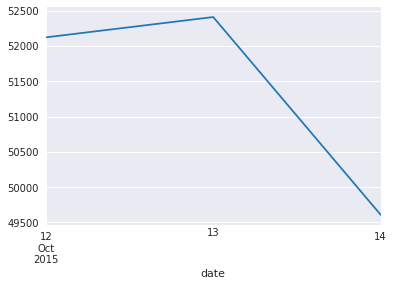

In [17]:
verify(['000977'],'2019-12-11')

In [51]:
data=QA.QAFetch.QATdx.QA_fetch_get_stock_list('stock')

In [4]:
data = QA.QAFetch.QATdx.QA_fetch_get_stock_block().blockname

QUANTAXIS>> Selecting the Best Server IP of TDX
Selecting the Best Server IP of TDX


BAD RESPONSE 180.153.39.51
DEFAULT STOCK IP is BAD, RETESTING
BAD RESPONSE 61.152.107.168
BAD RESPONSE 113.05.73.88
BAD RESPONSE 121.14.110.194
BAD RESPONSE 119.147.171.206
BAD RESPONSE 218.108.50.178
BAD RESPONSE 121.14.2.7
BAD RESPONSE 60.28.29.69
BAD RESPONSE 180.153.18.17
BAD RESPONSE hq.cjis.cn
BAD RESPONSE 59.173.18.69
BAD RESPONSE 61.153.144.179
BAD RESPONSE hq1.daton.com.cn
BAD RESPONSE 119.29.51.30
BAD RESPONSE 121.14.104.70
BAD RESPONSE 121.14.104.72
BAD RESPONSE 114.80.149.84
USING DEFAULT FUTURE IP


QUANTAXIS>> === The BEST SERVER ===
 stock_ip sztdx.gtjas.com future_ip 119.97.185.5
=== The BEST SERVER ===
 stock_ip sztdx.gtjas.com future_ip 119.97.185.5


In [8]:
data.unique()

array(['通达信88', '长三角', '泛珠三角', '环渤海', '海峡西岸', '成渝特区', '武汉规划', '皖江区域',
       '长株潭', '黄河三角', '东亚自贸', '朝鲜改革', '海南自贸', '一带一路', '上海自贸', '雄安新区',
       '粤港澳', 'ST板块', '次新股', '含H股', '含B股', '含GDR', '含可转债', '国防军工', '军民融合',
       '稀缺资源', '5G概念', '低碳经济', '黄金概念', '三网融合', '物联网', '创投概念', '铁路基建',
       '核电核能', '光伏概念', '多晶硅', '锂电池', '燃料电池', '氢能源', '稀土永磁', '水利建设',
       '卫星导航', '电子支付', '可燃冰', '海水淡化', '保障房', '涉矿概念', '页岩气', '生物疫苗',
       '基因概念', '抗癌', '抗流感', '维生素', '仿制药', '免疫治疗', 'IP变现', '节能', '金融改革',
       '农村金融', '高端装备', '食品安全', '奢侈品', '碳纤维', '石墨烯', '3D打印', '苹果概念',
       '阿里概念', '腾讯概念', '华为概念', '小米概念', '百度概念', '消费电子', '无线耳机', '生物质能',
       '地热能', '风能', '充电桩', '新能源车', '特斯拉', '汽车电子', '生态农业', '猪肉', '草甘膦',
       '安防服务', '建筑节能', '空气治理', '污水处理', '垃圾分类', '风沙治理', '装饰园林', '乡村振兴',
       '土地流转', '水产品', '体育概念', '博彩概念', '赛马概念', '分散染料', '聚氨酯', '绿色照明',
       '云计算', '网络游戏', '信息安全', '国产软件', '大数据', '芯片', '互联金融', '婴童概念', '养老概念',
       '电商概念', '网红经济', '网贷概念', '民营银行', '民营医院', '油气改革', '特高压', '智能电网',
       '智能穿戴

In [106]:
stockInTrade = QA.QA_fetch_get_stock_info('600797').liutongguben[0]
data = loadLocalData('600797','2018-01-01','2019-09-11')


QUANTAXIS>> load data from local DB
load data from local DB


In [73]:
data.data['SR']=data.data['amount']/(stockInTrade*3.6163793103448283)

In [107]:
code = data.data.index.get_level_values('code')[0]

In [117]:
data.data['SRatio']=data.data['volume']/QA.QA_fetch_get_stock_info(code).liutongguben[0]*100

In [125]:
data.data

open     high      low    close       volume  \
date       code                                                      
2019-01-02 000977  15.8835  15.9334  15.5642  15.8037  254040.2159   
           600797   7.2456   7.2755   7.1559   7.2755   45413.2231   
           601068   5.2051   5.2648   5.1453   5.2051  125590.9723   
           601069  14.7897  14.8397  13.3707  14.0003  131172.1551   
2019-01-03 000977  15.7937  16.0232  15.4844  15.4944  238872.4541   
           600797   7.2058   7.3553   7.2058   7.2357   62451.3341   
           601068   5.1652   5.2548   5.0856   5.1553  142095.6871   
           601069  13.8504  14.5399  13.6005  14.3800  119204.8387   
2019-01-04 000977  15.2550  16.1928  15.1751  16.1230  354798.1356   
           600797   7.1161   7.5347   7.0862   7.4848  113212.4832   
...                    ...      ...      ...      ...          ...   
2019-09-09 601068   6.2900   6.4300   6.2300   6.3400  222095.0000   
           601069  17.0100  17.3600  16.9000  17.3300  313136.0000   
2019-09-10 000977  28.1000  28.1200  26.3000  26.9700  510685.0000   
           600797   9.4200   9.4200   9.1300   9.2100  356345.0000   
           601068   6.3100   6.3600   6.2400   6.2900  158529.0000   
           601069  17.1600  17.5400  17.0100  17.3400  273868.0000   
2019-09-11 000977  27.0000  27.5200  26.6200  26.6800  356212.0000   
           600797   9.2300   9.3200   9.0800   9.1100  235883.0000   
           601068   6.3300   6.4200   6.2300   6.3500  234953.0000   
           601069  17.2900  17.4400  16.9400  16.9800  310994.0000   

                       amount  preclose     adj  
date       code                                  
2019-01-02 000977  4.0058e+08       NaN  0.9977  
           600797  3.2838e+07       NaN  0.9966  
           601068  6.5401e+07       NaN  0.9952  
           601069  1.8394e+08       NaN  0.9993  
2019-01-03 000977  3.7620e+08   15.8037  0.9977  
           600797  4.5441e+07    7.2755  0.9966  
           601068  7.3555e+07    5.2051  0.9952  
           601069  1.6830e+08   14.0003  0.9993  
2019-01-04 000977  5.6158e+08   15.4944  0.9977  
           600797  8.3578e+07    7.2357  0.9966  
...                       ...       ...     ...  
2019-09-09 601068  1.4025e+08    6.2100  1.0000  
           601069  5.3830e+08   16.9400  1.0000  
2019-09-10 000977  1.3814e+09   27.8000  1.0000  
           600797  3.2929e+08    9.4200  1.0000  
           601068  9.9594e+07    6.3400  1.0000  
           601069  4.7312e+08   17.3300  1.0000  
2019-09-11 000977  9.6392e+08   26.9700  1.0000  
           600797  2.1625e+08    9.2100  1.0000  
           601068  1.4880e+08    6.2900  1.0000  
           601069  5.3410e+08   17.3400  1.0000  

[684 rows x 8 columns]

In [112]:
QA.QA_fetch_get_stock_info('600797')

,market,code,liutongguben,province,industry,updated_date,ipo_date,zongguben,guojiagu,faqirenfarengu,...,touzishouyu,jingyingxianjinliu,zongxianjinliu,cunhuo,lirunzonghe,shuihoulirun,jinglirun,weifenpeilirun,meigujingzichan,baoliu2
0,1,600797,1.0238e+09,28,24,20190911,19970418,1.0466e+09,1.6870e+09,9.2802e+08,...,3.4446e+08,-2.0238e+09,-1.5069e+09,4.2599e+09,1.2310e+09,1.0800e+09,1.0815e+09,1.2516e+10,4.296,6.0


In [81]:
Account.history_table

,datetime,code,price,amount,cash,order_id,realorder_id,trade_id,account_cookie,commission,tax,message,frozen
0,2019-01-03 00:00:00,300123,5.07,5300,33122.2822,Order_ungwTi4r,Order_ungwTi4r,Trade_LZEiInCK,ECAP,6.7178,0.000,None,0
1,2019-01-08 00:00:00,002725,8.13,1700,19296.2822,Order_OvtZpWmU,Order_OvtZpWmU,Trade_7shp3b6O,ECAP,5.0000,0.000,None,0
2,2019-01-08 00:00:00,300123,5.34,-5300,47562.9047,Order_4OQXpk19,Order_4OQXpk19,Trade_RfLztdrk,ECAP,7.0755,28.302,None,0
3,2019-01-10 00:00:00,002725,9.08,-1700,62978.4687,Order_3mF8cbHz,Order_3mF8cbHz,Trade_TgP2veaH,ECAP,5.0000,15.436,None,0
4,2019-01-22 00:00:00,300134,11.13,2600,34033.2342,Order_fNQREmAM,Order_fNQREmAM,Trade_CZ5fJgyW,ECAP,7.2345,0.000,None,0
5,2019-01-23 00:00:00,300134,11.00,-2600,62597.4842,Order_YAmSCIwe,Order_YAmSCIwe,Trade_ryzN7Mld,ECAP,7.1500,28.600,None,0
6,2019-01-25 00:00:00,002786,8.76,3600,31053.6002,Order_vGVjRO7o,Order_vGVjRO7o,Trade_FQTJsfSG,ECAP,7.8840,0.000,None,0
7,2019-01-28 00:00:00,002786,8.92,-3600,63125.4602,Order_ymUBo1Q8,Order_ymUBo1Q8,Trade_zWG7saMK,ECAP,8.0280,32.112,None,0
8,2019-01-29 00:00:00,300493,6.20,4400,35838.6402,Order_ts7QNxOE,Order_ts7QNxOE,Trade_S0d3lWcs,ECAP,6.8200,0.000,None,0
9,2019-01-30 00:00:00,300493,6.03,-4400,62337.4752,Order_kvChuJje,Order_kvChuJje,Trade_ke3qEbRP,ECAP,6.6330,26.532,None,0


In [70]:
8.39/2.32

3.6163793103448283

In [126]:
ind.xs(codelist[-1],level=1)['2019-01'][:]

,open,high,low,close,volume,amount,preclose,adj,change,amplitude,SR,trend,amountRatio,single
date,,,,,,,,,,,,,,
2019-01-02,15.8835,15.9334,15.5642,15.8037,254040.2159,4.0058e+08,NaN,0.9977,0.000,0.000,0.0197,1.5655,0.8824,0
2019-01-03,15.7937,16.0232,15.4844,15.4944,238872.4541,3.7620e+08,15.8037,0.9977,-0.020,0.024,0.0185,1.5655,0.8287,0
2019-01-04,15.2550,16.1928,15.1751,16.1230,354798.1356,5.6158e+08,15.4944,0.9977,0.041,0.033,0.0275,1.5655,1.2371,0
2019-01-07,16.1329,16.5121,16.0631,16.4323,360228.5812,5.8835e+08,16.1230,0.9977,0.019,0.062,0.0279,1.5655,1.2960,1
2019-01-08,16.3624,16.4821,16.1030,16.2128,218036.7022,3.5471e+08,16.4323,0.9977,-0.013,0.028,0.0169,1.5655,0.7814,3
2019-01-09,16.2626,16.6917,16.1030,16.3026,306889.3369,5.0348e+08,16.2128,0.9977,0.006,0.023,0.0238,1.5655,1.1091,0
2019-01-10,16.2427,16.3923,15.8735,15.9334,242668.1532,3.9282e+08,16.3026,0.9977,-0.023,0.037,0.0188,1.5655,0.8653,0
2019-01-11,15.9633,16.2726,15.8935,16.0731,225631.1072,3.6263e+08,15.9334,0.9977,0.009,0.032,0.0175,0.9169,0.7552,0
2019-01-14,16.0930,16.1130,15.7139,15.7638,173779.2718,2.7552e+08,16.0731,0.9977,-0.019,0.024,0.0135,-1.5505,0.6256,0


In [37]:
if (-0.03>-0.05):
    print ('ok')

ok


In [15]:
class Solution:
    def combine(self, n, k):
        def backtrack(first = 1, curr = []):
            # if the combination is done
            if len(curr) == k:  
                output.append(curr[:])
                #print('got one {}'.format(curr[:]))
                #print('now the output is {}'.format(output))
            for i in range(first, n + 1):
                # add i into the current combination
                curr.append(i)
                #print('rount {} with stack {}'.format(i,curr))
                # use next integers to complete the combination
                backtrack(i + 1, curr)
                # backtrack
                curr.pop()
                #print('after {}'.format(curr))
        
        output = []
        backtrack()
        return output

so = Solution()
so.combine(10,3)

[[1, 2, 3],
 [1, 2, 4],
 [1, 2, 5],
 [1, 2, 6],
 [1, 2, 7],
 [1, 2, 8],
 [1, 2, 9],
 [1, 2, 10],
 [1, 3, 4],
 [1, 3, 5],
 [1, 3, 6],
 [1, 3, 7],
 [1, 3, 8],
 [1, 3, 9],
 [1, 3, 10],
 [1, 4, 5],
 [1, 4, 6],
 [1, 4, 7],
 [1, 4, 8],
 [1, 4, 9],
 [1, 4, 10],
 [1, 5, 6],
 [1, 5, 7],
 [1, 5, 8],
 [1, 5, 9],
 [1, 5, 10],
 [1, 6, 7],
 [1, 6, 8],
 [1, 6, 9],
 [1, 6, 10],
 [1, 7, 8],
 [1, 7, 9],
 [1, 7, 10],
 [1, 8, 9],
 [1, 8, 10],
 [1, 9, 10],
 [2, 3, 4],
 [2, 3, 5],
 [2, 3, 6],
 [2, 3, 7],
 [2, 3, 8],
 [2, 3, 9],
 [2, 3, 10],
 [2, 4, 5],
 [2, 4, 6],
 [2, 4, 7],
 [2, 4, 8],
 [2, 4, 9],
 [2, 4, 10],
 [2, 5, 6],
 [2, 5, 7],
 [2, 5, 8],
 [2, 5, 9],
 [2, 5, 10],
 [2, 6, 7],
 [2, 6, 8],
 [2, 6, 9],
 [2, 6, 10],
 [2, 7, 8],
 [2, 7, 9],
 [2, 7, 10],
 [2, 8, 9],
 [2, 8, 10],
 [2, 9, 10],
 [3, 4, 5],
 [3, 4, 6],
 [3, 4, 7],
 [3, 4, 8],
 [3, 4, 9],
 [3, 4, 10],
 [3, 5, 6],
 [3, 5, 7],
 [3, 5, 8],
 [3, 5, 9],
 [3, 5, 10],
 [3, 6, 7],
 [3, 6, 8],
 [3, 6, 9],
 [3, 6, 10],
 [3, 7, 8],
 [3, 7, 9],
 [3, 7, 10

In [4]:
for i in range(4):
    print (i)

0
1
2
3
